# Preparations

## Functions

In [1]:
import boto3
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.simplefilter("ignore")


In [2]:
! pip uninstall emagin-evaluation emagin-dataprep -y
! pip install --upgrade --extra-index-url https://pypi.myharviapp.com emagin-evaluation emagin-dataprep


Found existing installation: emagin-evaluation 0.0.3.1
Uninstalling emagin-evaluation-0.0.3.1:
  Successfully uninstalled emagin-evaluation-0.0.3.1
Found existing installation: emagin-dataprep 0.2.4
Uninstalling emagin-dataprep-0.2.4:
  Successfully uninstalled emagin-dataprep-0.2.4
Looking in indexes: https://pypi.org/simple, https://:****@pkgs.dev.azure.com/innovyze/global/_packaging/app_emagin360/pypi/simple/, https://pypi.myharviapp.com
     |████████████████████████████████| 40 kB 802 kB/s eta 0:00:011


ERROR: innovyze-sm 0.3.0 has requirement pandas==1.1.1, but you'll have pandas 1.1.3 which is incompatible.
ERROR: innovyze-sm 0.3.0 has requirement sagemaker==1.72.0, but you'll have sagemaker 2.15.4 which is incompatible.
You should consider upgrading via the '/Users/ashley.wang/Documents/Emagin/py3/bin/python -m pip install --upgrade pip' command.


In [2]:

import emagin_dataprep.cleaner as edpc
import emagin_dataprep.features as edpf

import emagin_evaluation.evaluations as emg_eval
from emagin_evaluation import Evaluator


In [3]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [4]:
def create_delta(df, col):
    df_copy = df.copy()
    
    delta_col = f'{col}_delta'
    df_copy[delta_col]=df_copy[col].diff(periods=1)
    df_copy[delta_col]=df_copy[delta_col].shift(-1)
    
    return df_copy

In [5]:
def train_test_split_ts(df, test_ratio=0.2):
    df_copy = df.copy()
    split_index = round(len(df_copy) * (1-test_ratio))
    return df_copy[:split_index], df_copy[split_index:]

## Load data

In [6]:
client = boto3.client('s3')
s3_bucket = 'dev-mle-ashley-2'


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [7]:
kruger_obj = client.get_object(Bucket=s3_bucket, Key='kruger_final_data.csv')
kruger_csv = kruger_obj['Body'].read().decode('utf-8')
kruger_df = pd.read_csv(StringIO(kruger_csv))

In [7]:
barrie_obj = client.get_object(Bucket=s3_bucket, Key='barrie_vine_measured.csv')
barrie_csv = barrie_obj['Body'].read().decode('utf-8')
barrie_df = pd.read_csv(StringIO(barrie_csv), index_col='DATE_TIME', parse_dates=True)

In [9]:
oldham_obj = client.get_object(Bucket=s3_bucket, Key='oldham_data_vine_updated_weather.csv')
oldham_csv = oldham_obj['Body'].read().decode('utf-8')
oldham_df = pd.read_csv(StringIO(oldham_csv), index_col='DATE_TIME', parse_dates=True)

In [10]:
mclf_obj = client.get_object(Bucket=s3_bucket, Key='macclesfield_historical_main1.csv')
mclf_csv = mclf_obj['Body'].read().decode('utf-8')
mclf_df = pd.read_csv(StringIO(mclf_csv), index_col='DATE_TIME', parse_dates=True)

In [ ]:
saur_obj = client.get_object(Bucket=s3_bucket, Key='wide_data.csv')
saur_csv = saur_obj['Body'].read().decode('utf-8')
saur_df = pd.read_csv(StringIO(saur_csv))

## Data clean

### Oldham

In [11]:
# remove outliers

SRs = [
    'Hatters_SR_Level_RESERVOIR_LEVEL',
    'Oldham_Edge_SR_Level_RESERVOIR_LEVEL',
    'Lowbrook_SR_Level_SERVICE_RESERVOIR_LEVEL',
    'Werneth_Park_SR_Level_RESERVOIR_LEVEL',
    'Westwood_SR_level_RESERVOIR_LEVEL',
    'Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL_',
    'Counthill_SR_1_COMP_A_PRI_LVL_SYS'
]

trimmer1 = edpc.ThresholdTrimmer(threshold=2, remove='less')
trimmer2 = edpc.ThresholdTrimmer(threshold=8, remove='greater')
# trimmer = edpc.DistributionOutlierTrimmer()

processor = edpc.ChannelProcessor(col_list=SRs, processes=[trimmer1, trimmer2])
oldham_sample = processor.transform(oldham_df)

INFO:ThresholdTrimmer:325 entries less than 2 removed from Hatters_SR_Level_RESERVOIR_LEVEL
INFO:ThresholdTrimmer:325 entries of column: Hatters_SR_Level_RESERVOIR_LEVEL has been removed
INFO:ThresholdTrimmer:5 entries greater than 8 removed from Hatters_SR_Level_RESERVOIR_LEVEL
INFO:ThresholdTrimmer:5 entries of column: Hatters_SR_Level_RESERVOIR_LEVEL has been removed
INFO:ThresholdTrimmer:37 entries less than 2 removed from Oldham_Edge_SR_Level_RESERVOIR_LEVEL
INFO:ThresholdTrimmer:37 entries of column: Oldham_Edge_SR_Level_RESERVOIR_LEVEL has been removed
INFO:ThresholdTrimmer:0 entries greater than 8 removed from Oldham_Edge_SR_Level_RESERVOIR_LEVEL
INFO:ThresholdTrimmer:0 entries of column: Oldham_Edge_SR_Level_RESERVOIR_LEVEL has been removed
INFO:ThresholdTrimmer:5 entries less than 2 removed from Lowbrook_SR_Level_SERVICE_RESERVOIR_LEVEL
INFO:ThresholdTrimmer:5 entries of column: Lowbrook_SR_Level_SERVICE_RESERVOIR_LEVEL has been removed
INFO:ThresholdTrimmer:0 entries greater

In [13]:
timers = ['time', 'hr', 'min', 'dayofmonth', 'dayofweek', 'month']
cyclic_timer = edpf.CyclicTimeExtracter(timers=timers)

oldham_sample = cyclic_timer.transform(oldham_sample)

In [49]:
oldham_sample = oldham_sample.dropna()

In [51]:
oldham_sample_train, oldham_sample_test = train_test_split_ts(oldham_sample)


### Barrie

In [8]:
barrie_df.rename(columns={'temperature_0':'Barrie_temperature','precip_0':'Barrie_precipitation'}, inplace = True)

barrie_df = create_delta(barrie_df, 'Harvie_reservoir_level')
barrie_df = create_delta(barrie_df, 'Maple_level')
barrie_df = create_delta(barrie_df, 'Reservoir1_level')
barrie_df = create_delta(barrie_df, 'Reservoir2_level')

# barrie_sample = barrie_df['2018-01-01':'2018-12-31 23:45']


In [9]:
barrie_df['Total_GAC_flow'] = barrie_df["GAC1_effluent_flow"] + barrie_df["GAC2_effluent_flow"] + barrie_df["GAC2_effluent_flow"]


In [10]:
timers = ['time', 'hr', 'min', 'dayofmonth', 'dayofweek', 'month']
cyclic_timer = edpf.CyclicTimeExtracter(timers=timers)

barrie_df = cyclic_timer.transform(barrie_df)

In [11]:
barrie_sample = barrie_df.dropna()

barrie_sample_train, barrie_sample_test = train_test_split_ts(barrie_sample)


### Macclesfield

In [19]:
mclf_sample= mclf_df['2018-06':'2019-09-28']


In [20]:
SRs = [
    'kerridge_SR_level',
    'coppice_SR_level_1', # 'coppice_SR_level_2',
    'hollins_SR_level_1', # 'hollins_SR_level_2', 
    'hurdsfield_SR_level_1', # 'hurdsfield_SR_level_2', 
    'knutsford_SR_level_2', # 'knutsford_SR_level_1', 'knutsford_SR_level_3', 'knutsford_SR_level_4',
    # 'wilmslow_SR_level_1', # 'wilmslow_SR_level_2', 
    'hilltop_SR_level_1', # 'hilltop_SR_level_1b', 'hilltop_SR_level_2', 'hilltop_SR_level_2b',
]

trimmer1 = edpc.ThresholdTrimmer(threshold=1, remove='less')
trimmer2 = edpc.ThresholdTrimmer(threshold=8, remove='greater')
# trimmer = edpc.DistributionOutlierTrimmer()

processor = edpc.ChannelProcessor(col_list=SRs, processes=[trimmer1, trimmer2])
mclf_sample = processor.transform(mclf_sample)

INFO:ThresholdTrimmer:9 entries less than 1 removed from kerridge_SR_level
INFO:ThresholdTrimmer:9 entries of column: kerridge_SR_level has been removed
INFO:ThresholdTrimmer:0 entries greater than 8 removed from kerridge_SR_level
INFO:ThresholdTrimmer:0 entries of column: kerridge_SR_level has been removed
INFO:ThresholdTrimmer:99 entries less than 1 removed from coppice_SR_level_1
INFO:ThresholdTrimmer:99 entries of column: coppice_SR_level_1 has been removed
INFO:ThresholdTrimmer:0 entries greater than 8 removed from coppice_SR_level_1
INFO:ThresholdTrimmer:0 entries of column: coppice_SR_level_1 has been removed
INFO:ThresholdTrimmer:190 entries less than 1 removed from hollins_SR_level_1
INFO:ThresholdTrimmer:190 entries of column: hollins_SR_level_1 has been removed
INFO:ThresholdTrimmer:0 entries greater than 8 removed from hollins_SR_level_1
INFO:ThresholdTrimmer:0 entries of column: hollins_SR_level_1 has been removed
INFO:ThresholdTrimmer:0 entries less than 1 removed from hu

In [21]:
mclf_sample = edpc.ThresholdTrimmer(threshold=20, remove='less', col='wilmslow_SR_level_1').transform(mclf_sample)

INFO:ThresholdTrimmer:168 entries less than 20 removed from wilmslow_SR_level_1
INFO:ThresholdTrimmer:168 entries of column: wilmslow_SR_level_1 has been removed


In [22]:
timers = ['time', 'hr', 'min', 'dayofmonth', 'dayofweek', 'month']
cyclic_timer = edpf.CyclicTimeExtracter(timers=timers)

mclf_sample = cyclic_timer.transform(mclf_sample)

In [23]:
mclf_sample = mclf_sample.dropna()

In [24]:
mclf_sample_train, mclf_sample_test = train_test_split_ts(mclf_sample)


# Correlations

## Barrie

### Harvie: controlled by pumps, (demand)

<img src="pics/harvie_reservoir.png" style="float: left; width: 400px;" />

1. Reservoir features: Harvie inflow, Harvie outflow, Big Bay flow, Harvie booster outflow


- Harvie inflow is modelled with HL header flow, Big Bay flow, lag of Harvie inflow, (demand)
- Harvie outflow is modelled with HL header flow, Big Bay flow, lag of Harvie outflow, (pump)

2. Plots

Whole data (2016-01-02 ~ 2019-10-07).
Use 2018's data.

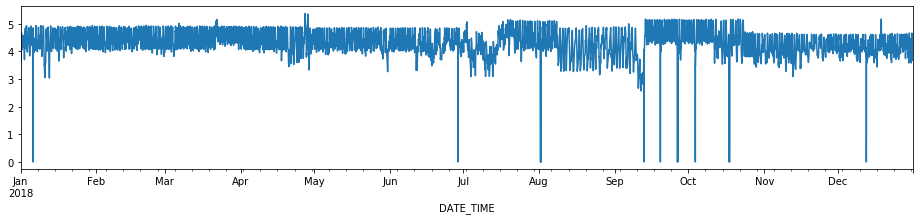

In [27]:
# Harvie reservoir - 2018

barrie_sample['Harvie_reservoir_level'].plot(figsize=(16,3)) # need to confirm the ranges

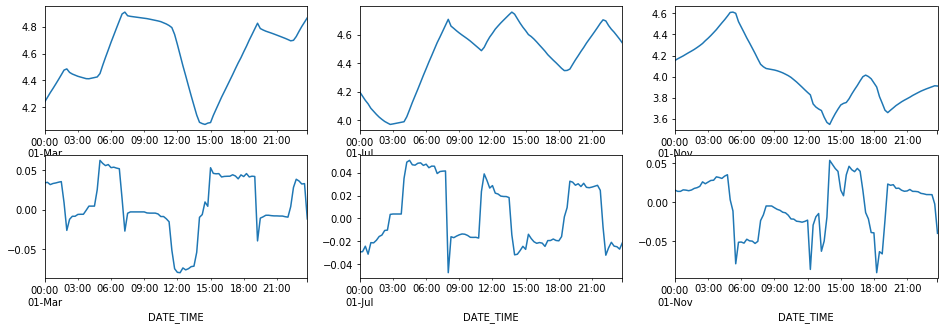

In [32]:
# Harvie reservoir - 1 day

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,5))

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['Harvie_reservoir_level'].plot(ax=axes[0,0])
barrie_sample['2018-07-01':'2018-07-01 23:45:00']['Harvie_reservoir_level'].plot(ax=axes[0,1])
barrie_sample['2018-11-01':'2018-11-01 23:45:00']['Harvie_reservoir_level'].plot(ax=axes[0,2])

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['Harvie_reservoir_level_delta'].plot(ax=axes[1,0])
barrie_sample['2018-07-01':'2018-07-01 23:45:00']['Harvie_reservoir_level_delta'].plot(ax=axes[1,1])
barrie_sample['2018-11-01':'2018-11-01 23:45:00']['Harvie_reservoir_level_delta'].plot(ax=axes[1,2])

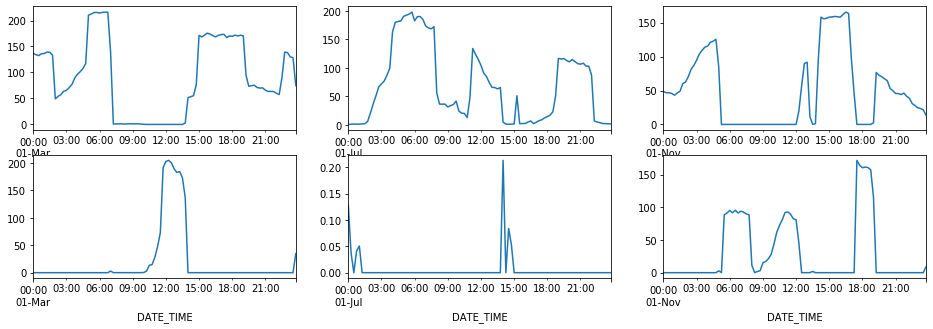

In [33]:
# Reservoir inflow & outflow

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,5))

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['Harvie_reservoir_inlet'].plot(ax=axes[0,0])
barrie_sample['2018-07-01':'2018-07-01 23:45:00']['Harvie_reservoir_inlet'].plot(ax=axes[0,1])
barrie_sample['2018-11-01':'2018-11-01 23:45:00']['Harvie_reservoir_inlet'].plot(ax=axes[0,2])

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['Harvie_outlet_flow_1'].plot(ax=axes[1,0])
barrie_sample['2018-07-01':'2018-07-01 23:45:00']['Harvie_outlet_flow_1'].plot(ax=axes[1,1])
barrie_sample['2018-11-01':'2018-11-01 23:45:00']['Harvie_outlet_flow_1'].plot(ax=axes[1,2])

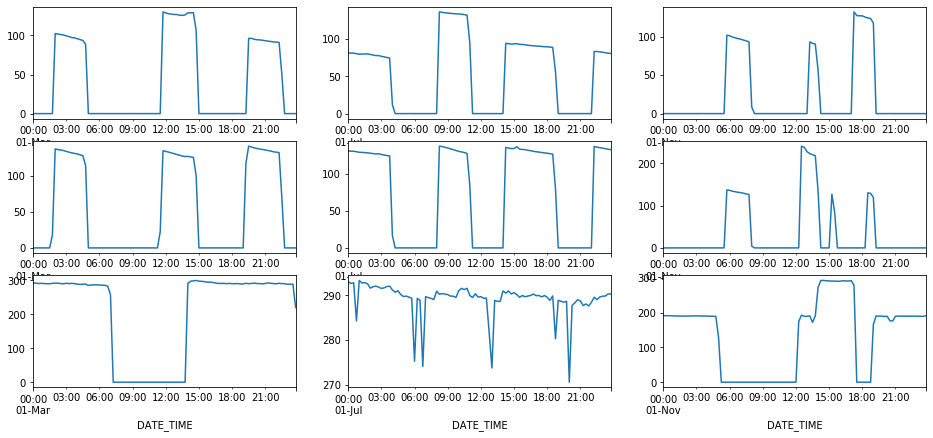

In [34]:
# Pump

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,7))

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['Big_Bay_Flow'].plot(ax=axes[0,0])
barrie_sample['2018-07-01':'2018-07-01 23:45:00']['Big_Bay_Flow'].plot(ax=axes[0,1])
barrie_sample['2018-11-01':'2018-11-01 23:45:00']['Big_Bay_Flow'].plot(ax=axes[0,2])

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['Harvie_booster_outlet_flow'].plot(ax=axes[1,0])
barrie_sample['2018-07-01':'2018-07-01 23:45:00']['Harvie_booster_outlet_flow'].plot(ax=axes[1,1])
barrie_sample['2018-11-01':'2018-11-01 23:45:00']['Harvie_booster_outlet_flow'].plot(ax=axes[1,2])

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['HL_discharge_header1_flow'].plot(ax=axes[2,0])
barrie_sample['2018-07-01':'2018-07-01 23:45:00']['HL_discharge_header1_flow'].plot(ax=axes[2,1])
barrie_sample['2018-11-01':'2018-11-01 23:45:00']['HL_discharge_header1_flow'].plot(ax=axes[2,2])

3. Correlations

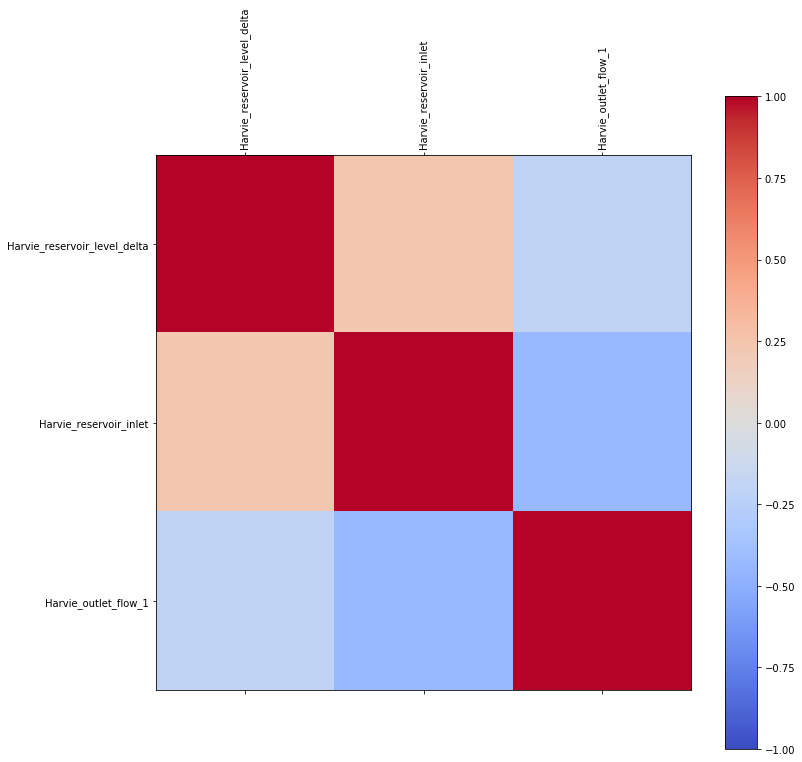

Harvie_reservoir_level_delta    1.000000
Harvie_reservoir_inlet          0.233825
Harvie_outlet_flow_1           -0.199722
Name: Harvie_reservoir_level_delta, dtype: float64


In [36]:
# Change of reservoir VS Harvie inflow & outflow

plot_corrrelation(barrie_sample[['Harvie_reservoir_level_delta', 'Harvie_reservoir_inlet', 'Harvie_outlet_flow_1']],
                  ['Harvie_reservoir_level_delta'])


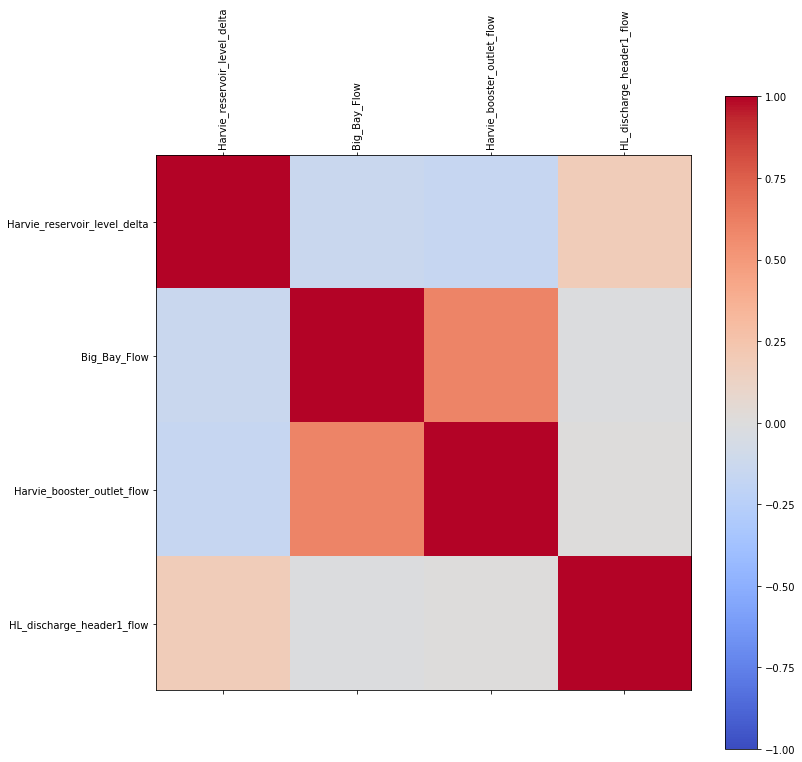

Harvie_reservoir_level_delta    1.000000
HL_discharge_header1_flow       0.183731
Harvie_booster_outlet_flow     -0.159711
Big_Bay_Flow                   -0.133706
Name: Harvie_reservoir_level_delta, dtype: float64


In [37]:
# Change of reservoir VS pump flows

plot_corrrelation(barrie_sample[['Harvie_reservoir_level_delta', 'Big_Bay_Flow', 'Harvie_booster_outlet_flow', 'HL_discharge_header1_flow']],
                  ['Harvie_reservoir_level_delta'])

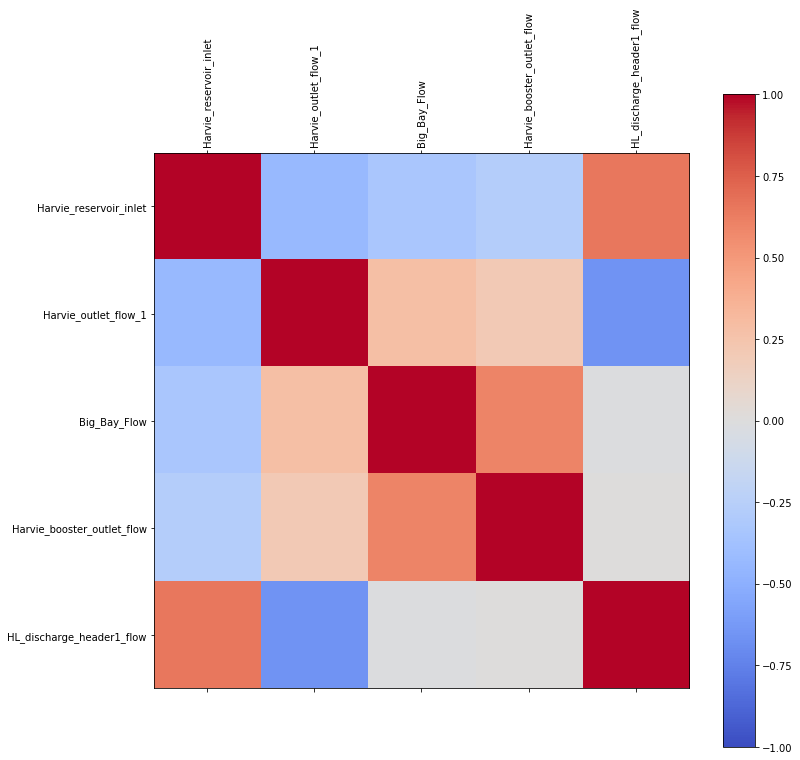

Harvie_reservoir_inlet        1.000000
HL_discharge_header1_flow     0.655696
Harvie_outlet_flow_1         -0.436984
Big_Bay_Flow                 -0.332005
Harvie_booster_outlet_flow   -0.265851
Name: Harvie_reservoir_inlet, dtype: float64
Harvie_outlet_flow_1          1.000000
HL_discharge_header1_flow    -0.657417
Harvie_reservoir_inlet       -0.436984
Big_Bay_Flow                  0.281480
Harvie_booster_outlet_flow    0.209265
Name: Harvie_outlet_flow_1, dtype: float64


In [38]:
# Harvie inflow, outflow VS pump flows

plot_corrrelation(barrie_sample[['Harvie_reservoir_inlet', 'Harvie_outlet_flow_1', 'Big_Bay_Flow', 'Harvie_booster_outlet_flow', 'HL_discharge_header1_flow']],
                  ['Harvie_reservoir_inlet', 'Harvie_outlet_flow_1'])


### Maple pump & demand

<img src="pics/maple_reservoir.png" style="float: left; width: 400px;" />

1. Features: maple inflow, maple outflow

Maple inflow and outflow is modelled with: Big bay flow, Harvie booster flow, temperature, precipitation, cyclic time

In [49]:
timers = ['hr', 'month', 'dayofweek']
cyclic_timer = edpm.CyclicTimeExtracter(timers=timers)

barrie_sample = cyclic_timer.transform(barrie_sample)

2. Plots

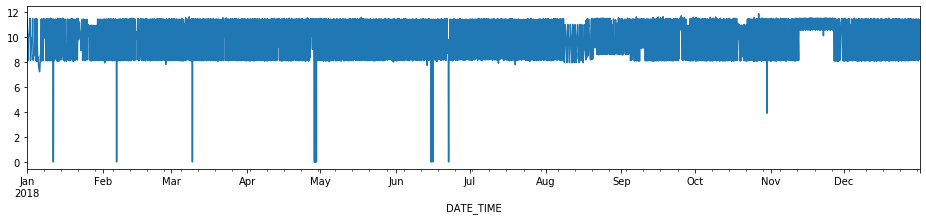

In [40]:
barrie_sample['Maple_level'].plot(figsize=(16,3)) # need to confirm the ranges

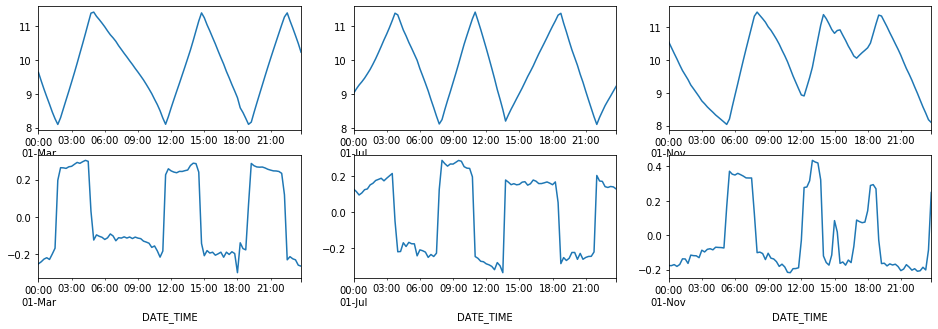

In [41]:
# Maple level - 1 day

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,5))

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['Maple_level'].plot(ax=axes[0,0])
barrie_sample['2018-07-01':'2018-07-01 23:45:00']['Maple_level'].plot(ax=axes[0,1])
barrie_sample['2018-11-01':'2018-11-01 23:45:00']['Maple_level'].plot(ax=axes[0,2])

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['Maple_level_delta'].plot(ax=axes[1,0])
barrie_sample['2018-07-01':'2018-07-01 23:45:00']['Maple_level_delta'].plot(ax=axes[1,1])
barrie_sample['2018-11-01':'2018-11-01 23:45:00']['Maple_level_delta'].plot(ax=axes[1,2])

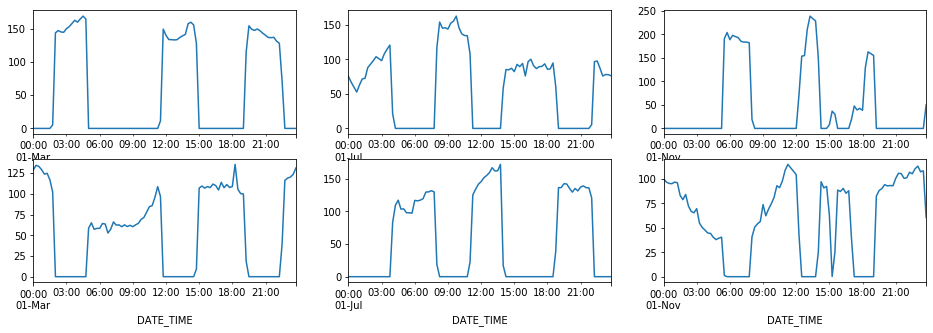

In [42]:
# Reservoir inflow & outflow

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,5))

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['Maple_inlet_flow'].plot(ax=axes[0,0])
barrie_sample['2018-07-01':'2018-07-01 23:45:00']['Maple_inlet_flow'].plot(ax=axes[0,1])
barrie_sample['2018-11-01':'2018-11-01 23:45:00']['Maple_inlet_flow'].plot(ax=axes[0,2])

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['Maple_outlet_flow'].plot(ax=axes[1,0])
barrie_sample['2018-07-01':'2018-07-01 23:45:00']['Maple_outlet_flow'].plot(ax=axes[1,1])
barrie_sample['2018-11-01':'2018-11-01 23:45:00']['Maple_outlet_flow'].plot(ax=axes[1,2])

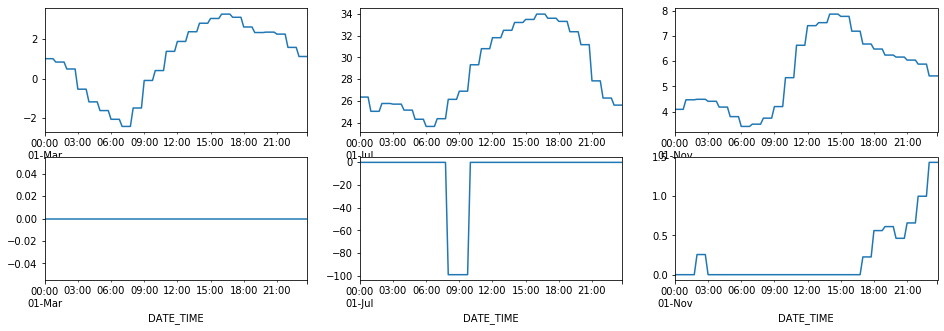

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,5))

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['Barrie_temperature'].plot(ax=axes[0,0])
barrie_sample['2018-07-01':'2018-07-01 23:45:00']['Barrie_temperature'].plot(ax=axes[0,1])
barrie_sample['2018-11-01':'2018-11-01 23:45:00']['Barrie_temperature'].plot(ax=axes[0,2])

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['Barrie_precipitation'].plot(ax=axes[1,0])
barrie_sample['2018-07-01':'2018-07-01 23:45:00']['Barrie_precipitation'].plot(ax=axes[1,1])
barrie_sample['2018-11-01':'2018-11-01 23:45:00']['Barrie_precipitation'].plot(ax=axes[1,2])

3. Correlations

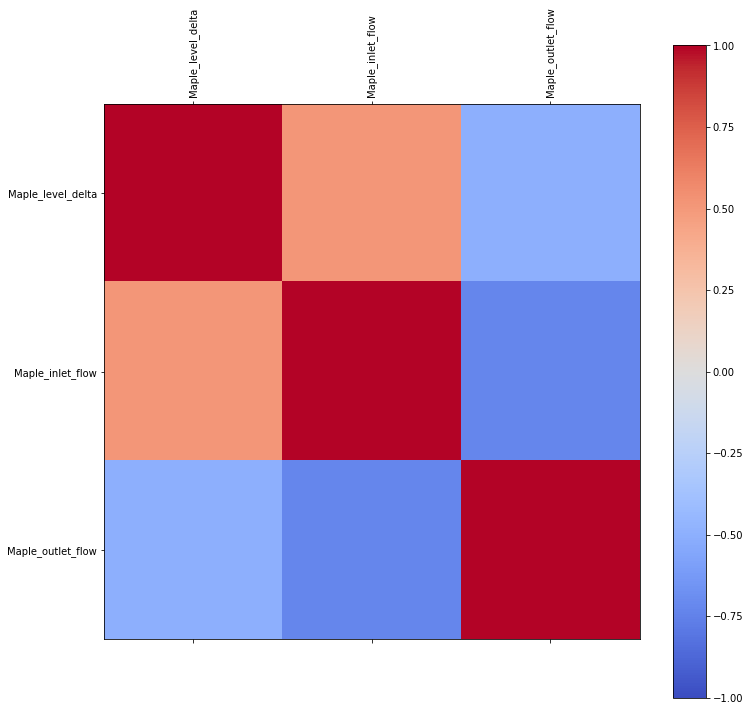

Maple_level_delta    1.000000
Maple_inlet_flow     0.510192
Maple_outlet_flow   -0.493128
Name: Maple_level_delta, dtype: float64


In [46]:
# Maple level VS Maple inflow outflow

plot_corrrelation(barrie_sample[['Maple_level_delta', 'Maple_inlet_flow', 'Maple_outlet_flow']],
                  ['Maple_level_delta'])


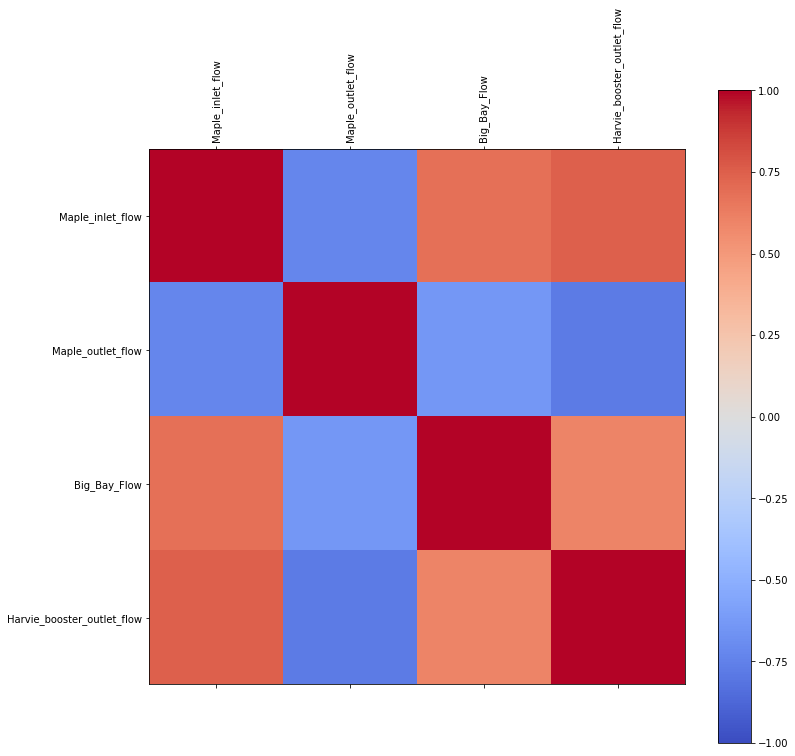

Maple_inlet_flow              1.000000
Harvie_booster_outlet_flow    0.742479
Maple_outlet_flow            -0.719408
Big_Bay_Flow                  0.686493
Name: Maple_inlet_flow, dtype: float64
Maple_outlet_flow             1.000000
Harvie_booster_outlet_flow   -0.774593
Maple_inlet_flow             -0.719408
Big_Bay_Flow                 -0.639492
Name: Maple_outlet_flow, dtype: float64


In [47]:
# Maple inflow outflow VS pumps

plot_corrrelation(barrie_sample[['Maple_inlet_flow', 'Maple_outlet_flow', 'Big_Bay_Flow', 'Harvie_booster_outlet_flow']],
                  ['Maple_inlet_flow', 'Maple_outlet_flow'])



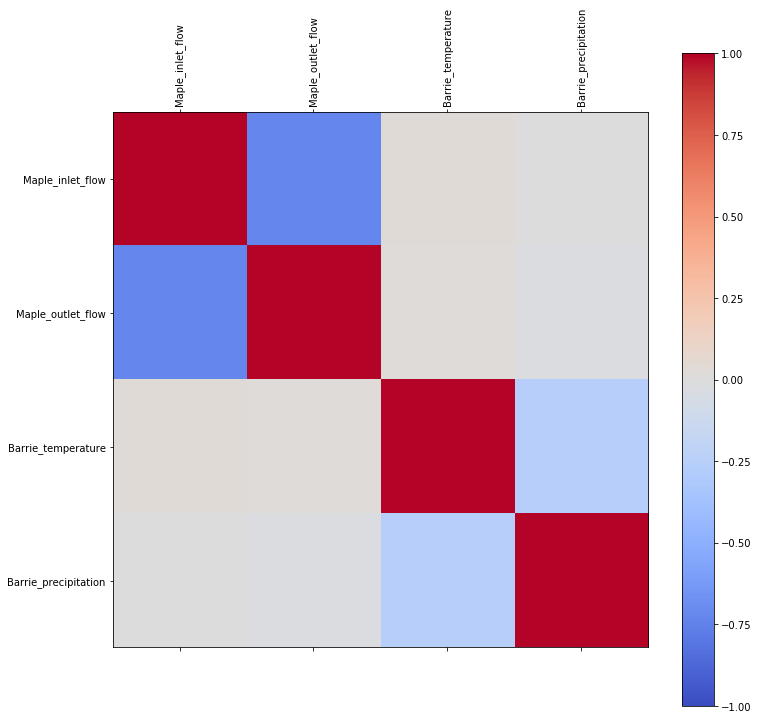

Maple_inlet_flow        1.000000
Maple_outlet_flow      -0.719408
Barrie_temperature      0.026207
Barrie_precipitation   -0.002509
Name: Maple_inlet_flow, dtype: float64
Maple_outlet_flow       1.000000
Maple_inlet_flow       -0.719408
Barrie_temperature      0.020377
Barrie_precipitation   -0.018206
Name: Maple_outlet_flow, dtype: float64


In [48]:
# Maple inflow outflow VS temperature precipitation

plot_corrrelation(barrie_sample[['Maple_inlet_flow', 'Maple_outlet_flow', 'Barrie_temperature', 'Barrie_precipitation']],
                  ['Maple_inlet_flow', 'Maple_outlet_flow'])


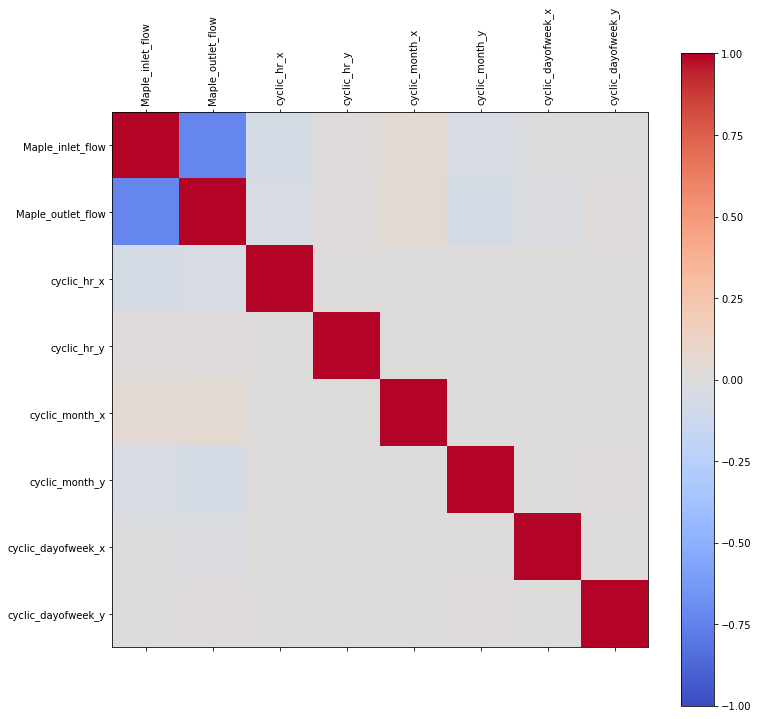

Maple_inlet_flow      1.000000
Maple_outlet_flow    -0.719408
cyclic_hr_x          -0.061665
cyclic_month_y       -0.049212
cyclic_month_x        0.041481
cyclic_hr_y           0.012488
cyclic_dayofweek_x   -0.010160
cyclic_dayofweek_y    0.003882
Name: Maple_inlet_flow, dtype: float64
Maple_outlet_flow     1.000000
Maple_inlet_flow     -0.719408
cyclic_month_y       -0.057950
cyclic_month_x        0.048854
cyclic_hr_x          -0.040312
cyclic_dayofweek_x   -0.016797
cyclic_dayofweek_y    0.008983
cyclic_hr_y           0.008554
Name: Maple_outlet_flow, dtype: float64


In [52]:
# inflow outflow VS cyclic time

plot_corrrelation(barrie_sample[['Maple_inlet_flow', 'Maple_outlet_flow', 'cyclic_hr_x', 'cyclic_hr_y', 
                                 'cyclic_month_x', 'cyclic_month_y', 'cyclic_dayofweek_x', 'cyclic_dayofweek_y']],
                  ['Maple_inlet_flow', 'Maple_outlet_flow'])


### Permeate reservoir: valve, pump

<img src="pics/permeate.png" style="float: left; width: 400px;" />

1. Features: CCT inflow, HL header flow


- CCT flow is modelled with: GAC flow, CCT valves
- HL header flow is modelled with: 6 HLP run status

2. Plots

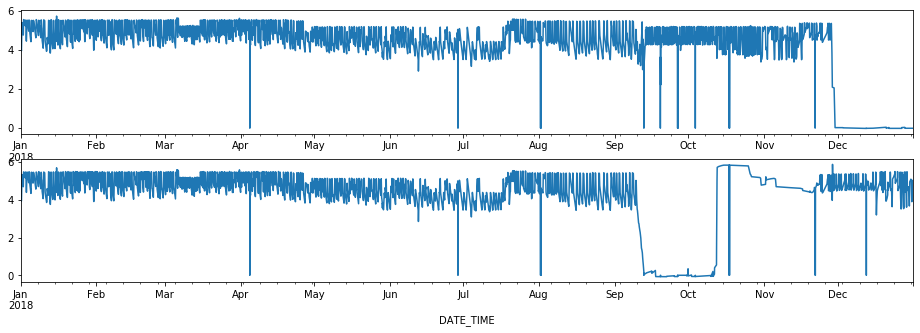

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,5))

barrie_sample['Reservoir1_level'].plot(ax=axes[0])
barrie_sample['Reservoir2_level'].plot(ax=axes[1])


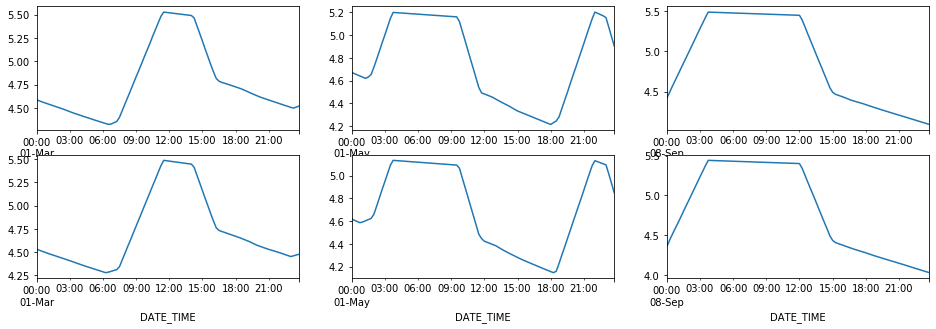

In [61]:
# daily plots of permeate reservoir

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,5))

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['Reservoir1_level'].plot(ax=axes[0,0])
barrie_sample['2018-05-01':'2018-05-01 23:45:00']['Reservoir1_level'].plot(ax=axes[0,1])
barrie_sample['2018-09-08':'2018-09-08 23:45:00']['Reservoir1_level'].plot(ax=axes[0,2])

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['Reservoir2_level'].plot(ax=axes[1,0])
barrie_sample['2018-05-01':'2018-05-01 23:45:00']['Reservoir2_level'].plot(ax=axes[1,1])
barrie_sample['2018-09-08':'2018-09-08 23:45:00']['Reservoir2_level'].plot(ax=axes[1,2])


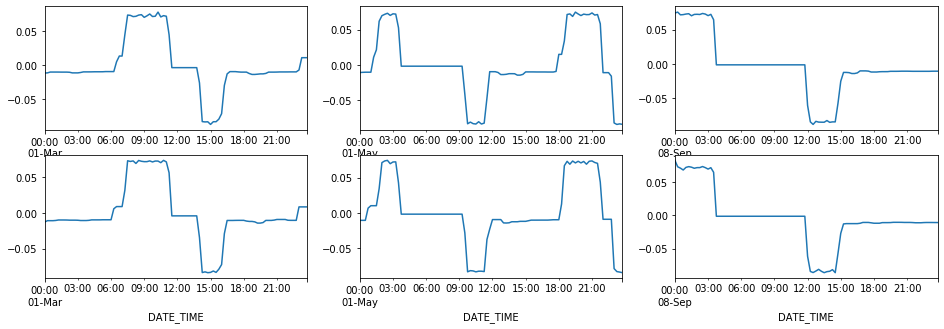

In [62]:
# daily plots of permeate reservoir

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,5))

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['Reservoir1_level_delta'].plot(ax=axes[0,0])
barrie_sample['2018-05-01':'2018-05-01 23:45:00']['Reservoir1_level_delta'].plot(ax=axes[0,1])
barrie_sample['2018-09-08':'2018-09-08 23:45:00']['Reservoir1_level_delta'].plot(ax=axes[0,2])

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['Reservoir2_level_delta'].plot(ax=axes[1,0])
barrie_sample['2018-05-01':'2018-05-01 23:45:00']['Reservoir2_level_delta'].plot(ax=axes[1,1])
barrie_sample['2018-09-08':'2018-09-08 23:45:00']['Reservoir2_level_delta'].plot(ax=axes[1,2])


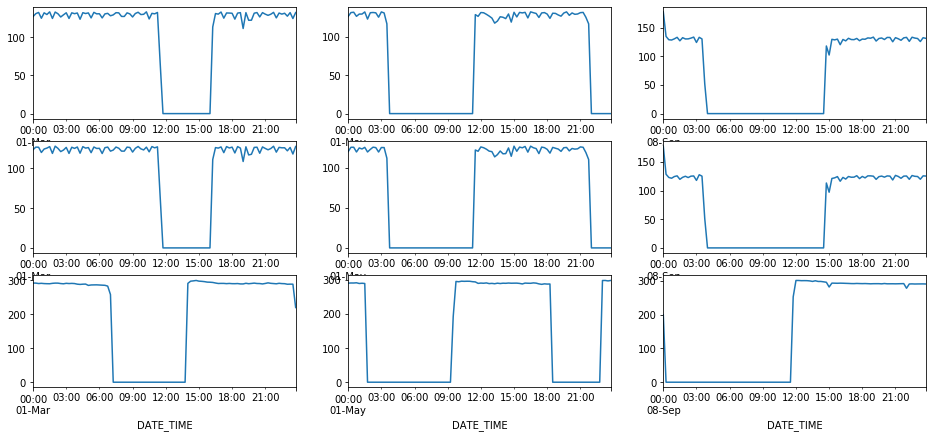

In [63]:
# inflow outflow

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,7))

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['CCT1_inlet_flow'].plot(ax=axes[0,0])
barrie_sample['2018-05-01':'2018-05-01 23:45:00']['CCT1_inlet_flow'].plot(ax=axes[0,1])
barrie_sample['2018-09-08':'2018-09-08 23:45:00']['CCT1_inlet_flow'].plot(ax=axes[0,2])

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['CCT2_inlet_flow'].plot(ax=axes[1,0])
barrie_sample['2018-05-01':'2018-05-01 23:45:00']['CCT2_inlet_flow'].plot(ax=axes[1,1])
barrie_sample['2018-09-08':'2018-09-08 23:45:00']['CCT2_inlet_flow'].plot(ax=axes[1,2])

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['HL_discharge_header1_flow'].plot(ax=axes[2,0])
barrie_sample['2018-05-01':'2018-05-01 23:45:00']['HL_discharge_header1_flow'].plot(ax=axes[2,1])
barrie_sample['2018-09-08':'2018-09-08 23:45:00']['HL_discharge_header1_flow'].plot(ax=axes[2,2])


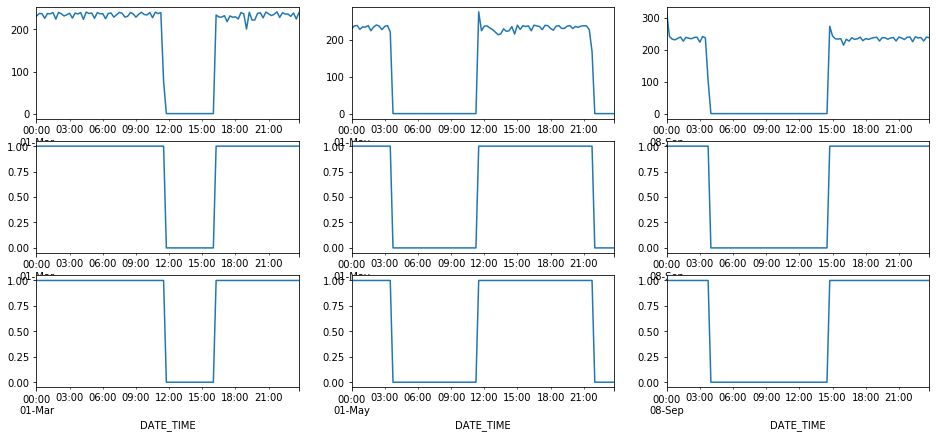

In [70]:
# (CCT flow:) GAC flow, CCT valves

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,7))

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['Total_GAC_flow'].plot(ax=axes[0,0])
barrie_sample['2018-05-01':'2018-05-01 23:45:00']['Total_GAC_flow'].plot(ax=axes[0,1])
barrie_sample['2018-09-08':'2018-09-08 23:45:00']['Total_GAC_flow'].plot(ax=axes[0,2])

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['CCT1_valve_position'].plot(ax=axes[1,0])
barrie_sample['2018-05-01':'2018-05-01 23:45:00']['CCT1_valve_position'].plot(ax=axes[1,1])
barrie_sample['2018-09-08':'2018-09-08 23:45:00']['CCT1_valve_position'].plot(ax=axes[1,2])

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['CCT2_valve_position'].plot(ax=axes[2,0])
barrie_sample['2018-05-01':'2018-05-01 23:45:00']['CCT2_valve_position'].plot(ax=axes[2,1])
barrie_sample['2018-09-08':'2018-09-08 23:45:00']['CCT2_valve_position'].plot(ax=axes[2,2])


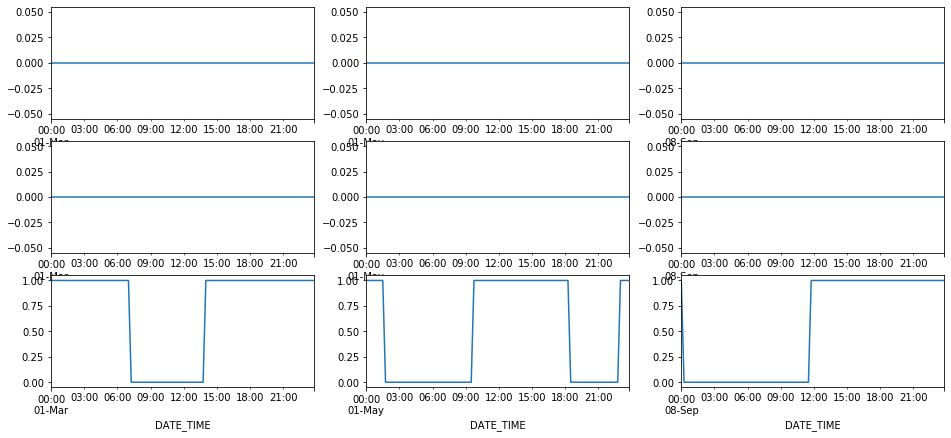

In [71]:
# HLP run status

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,7))

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['HLP1_run_status'].plot(ax=axes[0,0])
barrie_sample['2018-05-01':'2018-05-01 23:45:00']['HLP1_run_status'].plot(ax=axes[0,1])
barrie_sample['2018-09-08':'2018-09-08 23:45:00']['HLP1_run_status'].plot(ax=axes[0,2])

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['HLP2_run_status'].plot(ax=axes[1,0])
barrie_sample['2018-05-01':'2018-05-01 23:45:00']['HLP2_run_status'].plot(ax=axes[1,1])
barrie_sample['2018-09-08':'2018-09-08 23:45:00']['HLP2_run_status'].plot(ax=axes[1,2])

barrie_sample['2018-03-01':'2018-03-01 23:45:00']['HLP3_run_status'].plot(ax=axes[2,0])
barrie_sample['2018-05-01':'2018-05-01 23:45:00']['HLP3_run_status'].plot(ax=axes[2,1])
barrie_sample['2018-09-08':'2018-09-08 23:45:00']['HLP3_run_status'].plot(ax=axes[2,2])


3. Correlations

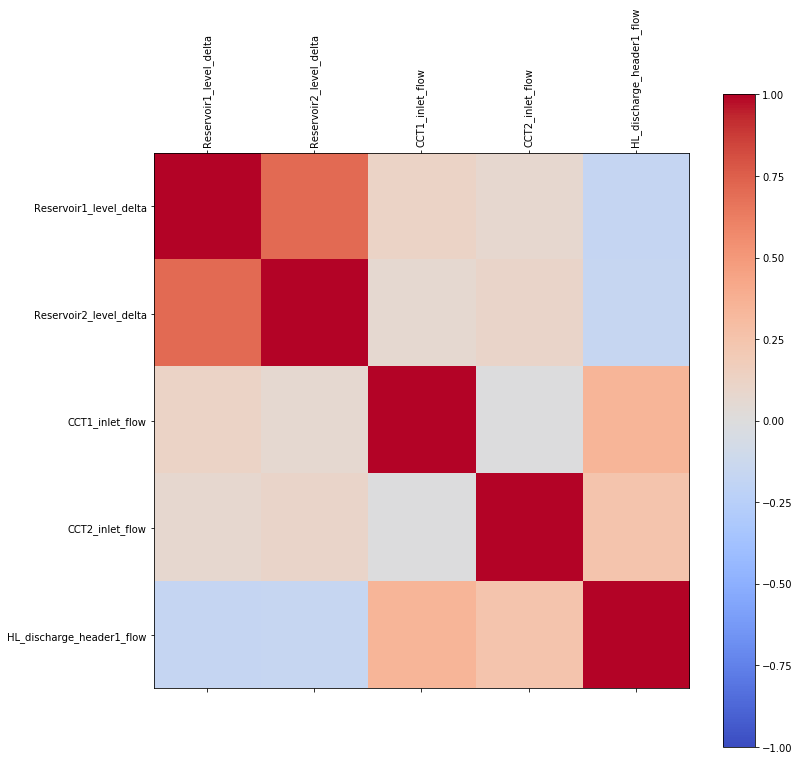

Reservoir1_level_delta       1.000000
Reservoir2_level_delta       0.710809
HL_discharge_header1_flow   -0.167388
CCT1_inlet_flow              0.118950
CCT2_inlet_flow              0.071044
Name: Reservoir1_level_delta, dtype: float64
Reservoir2_level_delta       1.000000
Reservoir1_level_delta       0.710809
HL_discharge_header1_flow   -0.159519
CCT2_inlet_flow              0.108957
CCT1_inlet_flow              0.068877
Name: Reservoir2_level_delta, dtype: float64


In [72]:
# reservoir change VS inflow outflow

plot_corrrelation(barrie_sample[['Reservoir1_level_delta', 'Reservoir2_level_delta', 'CCT1_inlet_flow', 'CCT2_inlet_flow', 
                                 'HL_discharge_header1_flow']],
                  ['Reservoir1_level_delta', 'Reservoir2_level_delta'])


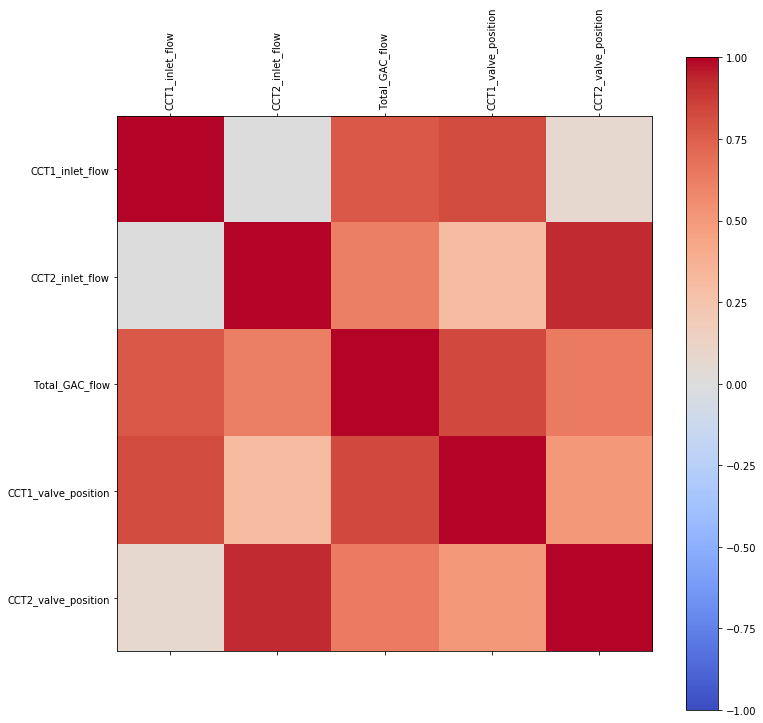

CCT1_inlet_flow        1.000000
CCT1_valve_position    0.823483
Total_GAC_flow         0.776738
CCT2_valve_position    0.075235
CCT2_inlet_flow       -0.004494
Name: CCT1_inlet_flow, dtype: float64
CCT2_inlet_flow        1.000000
CCT2_valve_position    0.926126
Total_GAC_flow         0.617579
CCT1_valve_position    0.300733
CCT1_inlet_flow       -0.004494
Name: CCT2_inlet_flow, dtype: float64


In [74]:
# inflow VS valves & upstream flow

plot_corrrelation(barrie_sample[['CCT1_inlet_flow', 'CCT2_inlet_flow', 'Total_GAC_flow',
                                'CCT1_valve_position', 'CCT2_valve_position']],
                  ['CCT1_inlet_flow', 'CCT2_inlet_flow'])


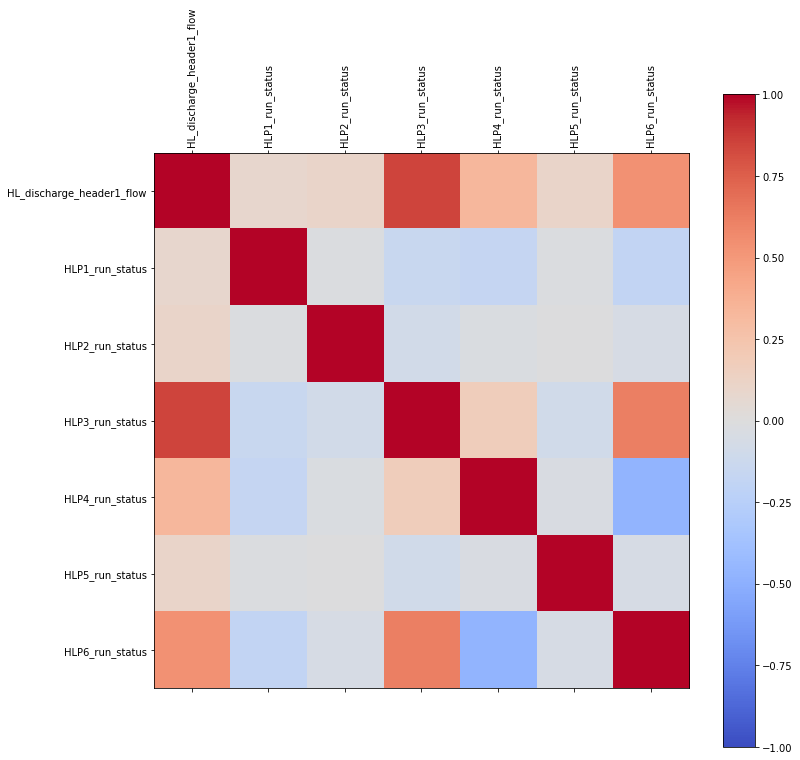

HL_discharge_header1_flow    1.000000
HLP3_run_status              0.844939
HLP6_run_status              0.535089
HLP4_run_status              0.328482
HLP5_run_status              0.109225
HLP2_run_status              0.104348
HLP1_run_status              0.083870
Name: HL_discharge_header1_flow, dtype: float64


In [75]:
# outflow VS pump run status

plot_corrrelation(barrie_sample[['HL_discharge_header1_flow', 'HLP1_run_status', 'HLP2_run_status', 'HLP3_run_status', 
                                 'HLP4_run_status', 'HLP5_run_status', 'HLP6_run_status']],
                  ['HL_discharge_header1_flow'])



## Oldham

<img src="pics/oldham.png" style="float: left; width: 850px;" />

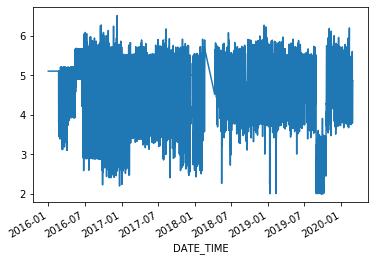

In [49]:
oldham_sample['Hatters_SR_Level_RESERVOIR_LEVEL'].plot()

### Pumps + demand

- Hatters SR: pump run status, cyclic time
- Oldham Edge: pump run status, demand
- Lowbrook SR: pump status, demand
- Westwood SR: pump status & flow, cyclic time, weather
- Sholver SR: cyclic time, demand flows
- Counthill SR: pump run status, demand flows



1. Reservoir level VS pump run status / flows, demand flows

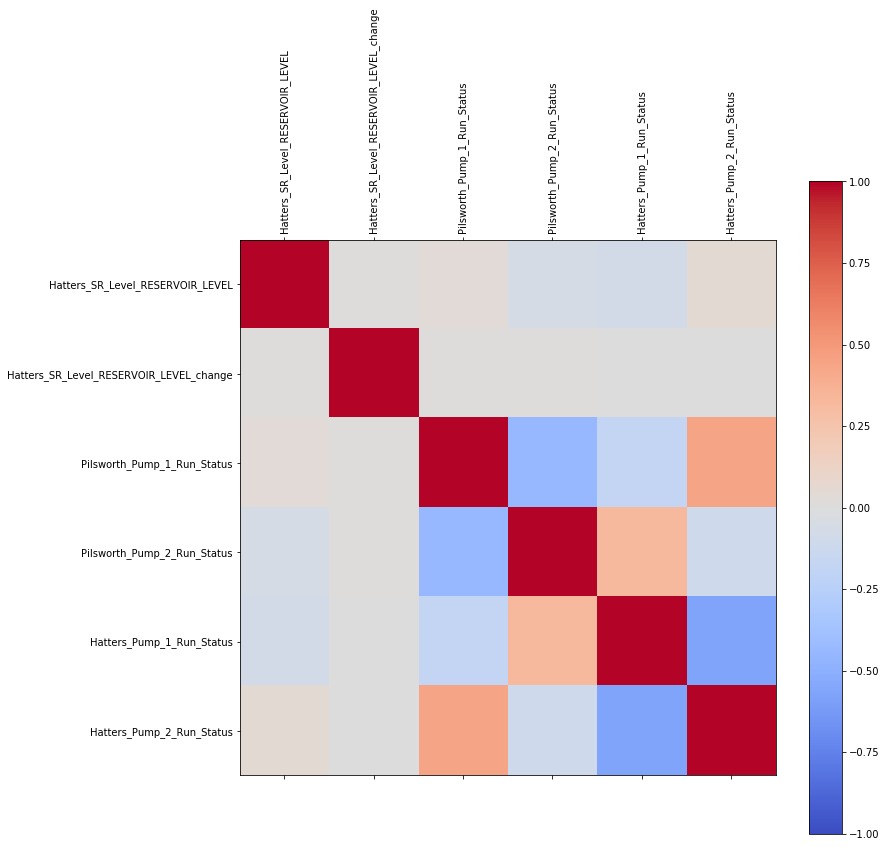

Hatters_SR_Level_RESERVOIR_LEVEL           1.000000
Hatters_Pump_1_Run_Status                 -0.077835
Pilsworth_Pump_2_Run_Status               -0.061347
Hatters_Pump_2_Run_Status                  0.053506
Pilsworth_Pump_1_Run_Status                0.035985
Hatters_SR_Level_RESERVOIR_LEVEL_change    0.003290
Name: Hatters_SR_Level_RESERVOIR_LEVEL, dtype: float64
Hatters_SR_Level_RESERVOIR_LEVEL_change    1.000000
Hatters_SR_Level_RESERVOIR_LEVEL           0.003290
Pilsworth_Pump_1_Run_Status                0.000224
Pilsworth_Pump_2_Run_Status                0.000137
Hatters_Pump_2_Run_Status                 -0.000048
Hatters_Pump_1_Run_Status                 -0.000041
Name: Hatters_SR_Level_RESERVOIR_LEVEL_change, dtype: float64


In [52]:
Hatters_col = [
    "Hatters_SR_Level_RESERVOIR_LEVEL",
    "Hatters_SR_Level_RESERVOIR_LEVEL_change",
    "Pilsworth_Pump_1_Run_Status",
     "Pilsworth_Pump_2_Run_Status",
     "Hatters_Pump_1_Run_Status",
     "Hatters_Pump_2_Run_Status"
]

plot_correlation(oldham_sample[Hatters_col], 
                 ["Hatters_SR_Level_RESERVOIR_LEVEL", "Hatters_SR_Level_RESERVOIR_LEVEL_change"])


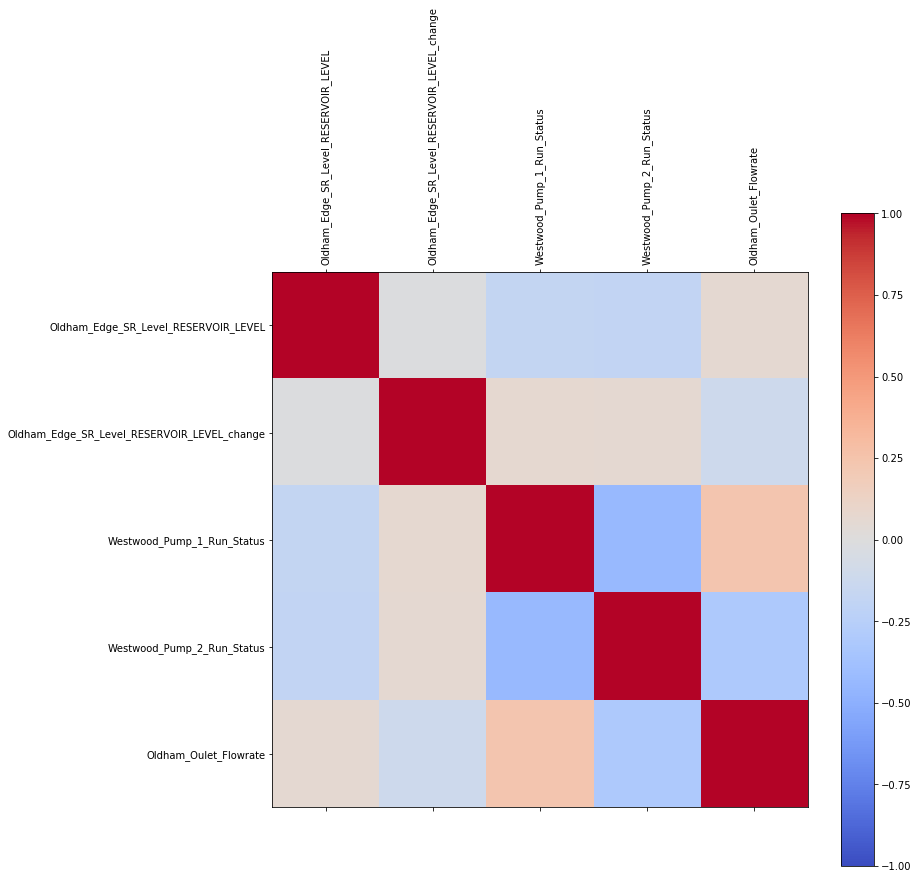

Oldham_Edge_SR_Level_RESERVOIR_LEVEL           1.000000
Westwood_Pump_2_Run_Status                    -0.183359
Westwood_Pump_1_Run_Status                    -0.172080
Oldham_Oulet_Flowrate                          0.055050
Oldham_Edge_SR_Level_RESERVOIR_LEVEL_change   -0.009978
Name: Oldham_Edge_SR_Level_RESERVOIR_LEVEL, dtype: float64
Oldham_Edge_SR_Level_RESERVOIR_LEVEL_change    1.000000
Oldham_Oulet_Flowrate                         -0.111065
Westwood_Pump_1_Run_Status                     0.070214
Westwood_Pump_2_Run_Status                     0.062055
Oldham_Edge_SR_Level_RESERVOIR_LEVEL          -0.009978
Name: Oldham_Edge_SR_Level_RESERVOIR_LEVEL_change, dtype: float64


In [53]:
Oldham_col = [
    "Oldham_Edge_SR_Level_RESERVOIR_LEVEL",
    "Oldham_Edge_SR_Level_RESERVOIR_LEVEL_change",
    "Westwood_Pump_1_Run_Status",
     "Westwood_Pump_2_Run_Status",
     "Oldham_Oulet_Flowrate" # demand flow
]


plot_correlation(oldham_sample[Oldham_col], 
                 ["Oldham_Edge_SR_Level_RESERVOIR_LEVEL", "Oldham_Edge_SR_Level_RESERVOIR_LEVEL_change"])


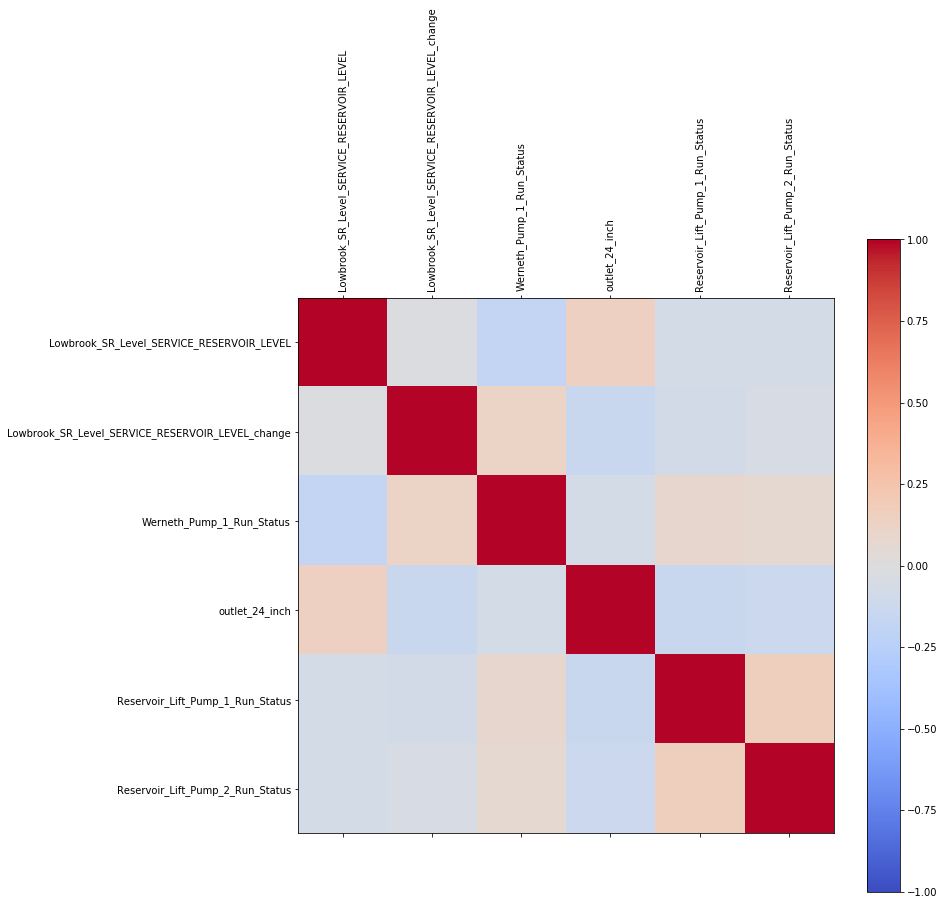

Lowbrook_SR_Level_SERVICE_RESERVOIR_LEVEL           1.000000
Werneth_Pump_1_Run_Status                          -0.178140
outlet_24_inch                                      0.142984
Reservoir_Lift_Pump_1_Run_Status                   -0.066035
Reservoir_Lift_Pump_2_Run_Status                   -0.064979
Lowbrook_SR_Level_SERVICE_RESERVOIR_LEVEL_change   -0.016606
Name: Lowbrook_SR_Level_SERVICE_RESERVOIR_LEVEL, dtype: float64
Lowbrook_SR_Level_SERVICE_RESERVOIR_LEVEL_change    1.000000
outlet_24_inch                                     -0.136842
Werneth_Pump_1_Run_Status                           0.119245
Reservoir_Lift_Pump_1_Run_Status                   -0.074016
Reservoir_Lift_Pump_2_Run_Status                   -0.054330
Lowbrook_SR_Level_SERVICE_RESERVOIR_LEVEL          -0.016606
Name: Lowbrook_SR_Level_SERVICE_RESERVOIR_LEVEL_change, dtype: float64


In [54]:
Lowbrook_col = [
    "Lowbrook_SR_Level_SERVICE_RESERVOIR_LEVEL",
    "Lowbrook_SR_Level_SERVICE_RESERVOIR_LEVEL_change",
    "Werneth_Pump_1_Run_Status",
     "outlet_24_inch", # demand flow
     "Reservoir_Lift_Pump_1_Run_Status",
     "Reservoir_Lift_Pump_2_Run_Status"
]

plot_correlation(oldham_sample[Lowbrook_col], 
                 ["Lowbrook_SR_Level_SERVICE_RESERVOIR_LEVEL", "Lowbrook_SR_Level_SERVICE_RESERVOIR_LEVEL_change"])


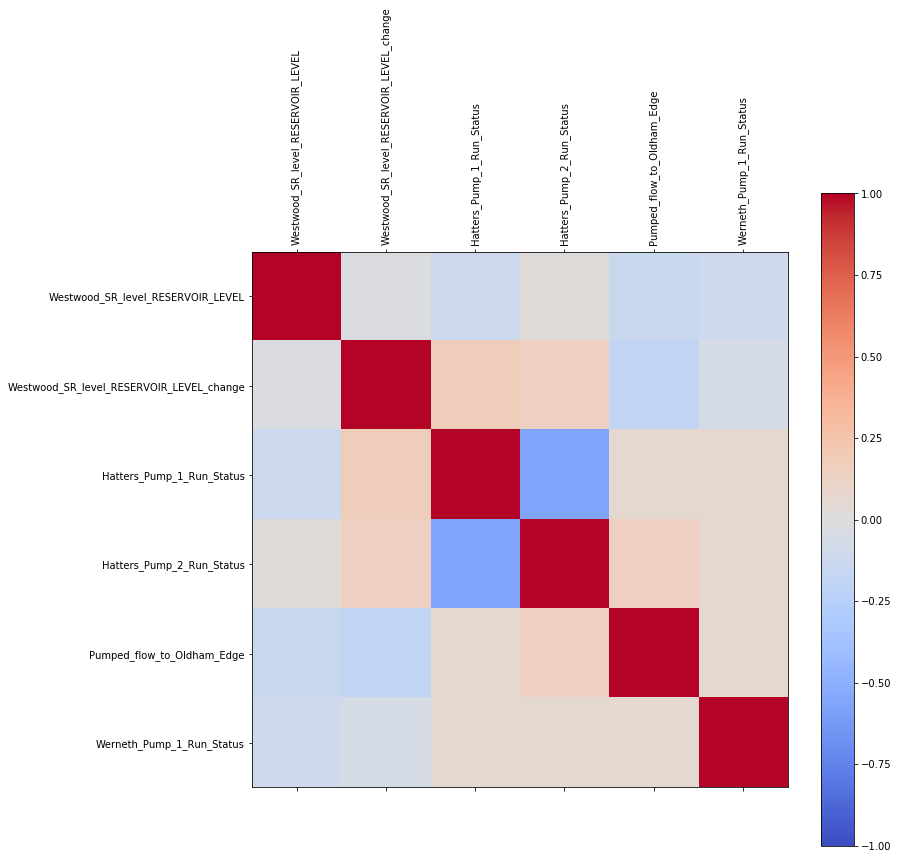

Westwood_SR_level_RESERVOIR_LEVEL           1.000000
Pumped_flow_to_Oldham_Edge                 -0.136863
Hatters_Pump_1_Run_Status                  -0.118333
Werneth_Pump_1_Run_Status                  -0.108697
Westwood_SR_level_RESERVOIR_LEVEL_change   -0.022452
Hatters_Pump_2_Run_Status                   0.016993
Name: Westwood_SR_level_RESERVOIR_LEVEL, dtype: float64
Westwood_SR_level_RESERVOIR_LEVEL_change    1.000000
Pumped_flow_to_Oldham_Edge                 -0.183461
Hatters_Pump_1_Run_Status                   0.174842
Hatters_Pump_2_Run_Status                   0.145997
Werneth_Pump_1_Run_Status                  -0.055453
Westwood_SR_level_RESERVOIR_LEVEL          -0.022452
Name: Westwood_SR_level_RESERVOIR_LEVEL_change, dtype: float64


In [55]:
Westwood_col = [
    "Westwood_SR_level_RESERVOIR_LEVEL",
    "Westwood_SR_level_RESERVOIR_LEVEL_change",
    "Hatters_Pump_1_Run_Status",
     "Hatters_Pump_2_Run_Status",
     "Pumped_flow_to_Oldham_Edge",
     "Werneth_Pump_1_Run_Status",
]

plot_correlation(oldham_sample[Westwood_col], 
                 ["Westwood_SR_level_RESERVOIR_LEVEL", "Westwood_SR_level_RESERVOIR_LEVEL_change"])


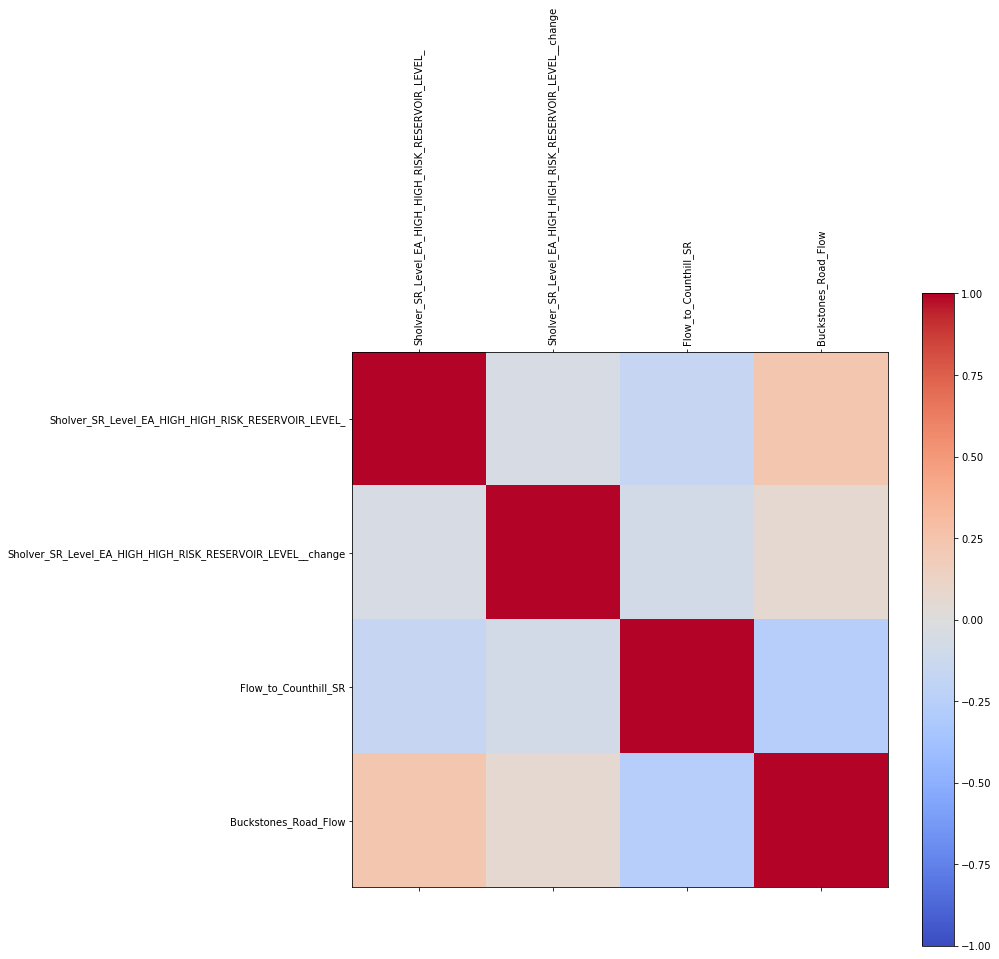

Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL_           1.000000
Buckstones_Road_Flow                                          0.229276
Flow_to_Counthill_SR                                         -0.165510
Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL__change   -0.048367
Name: Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL_, dtype: float64
Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL__change    1.000000
Flow_to_Counthill_SR                                         -0.071938
Buckstones_Road_Flow                                          0.064711
Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL_          -0.048367
Name: Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL__change, dtype: float64


In [60]:
Sholver_col = [
    'Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL_',
    'Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL__change',
     "Flow_to_Counthill_SR", # demand flow
     "Buckstones_Road_Flow" # demand flow
]

plot_correlation(oldham_sample[Sholver_col], 
                 ["Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL_", "Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL__change"])


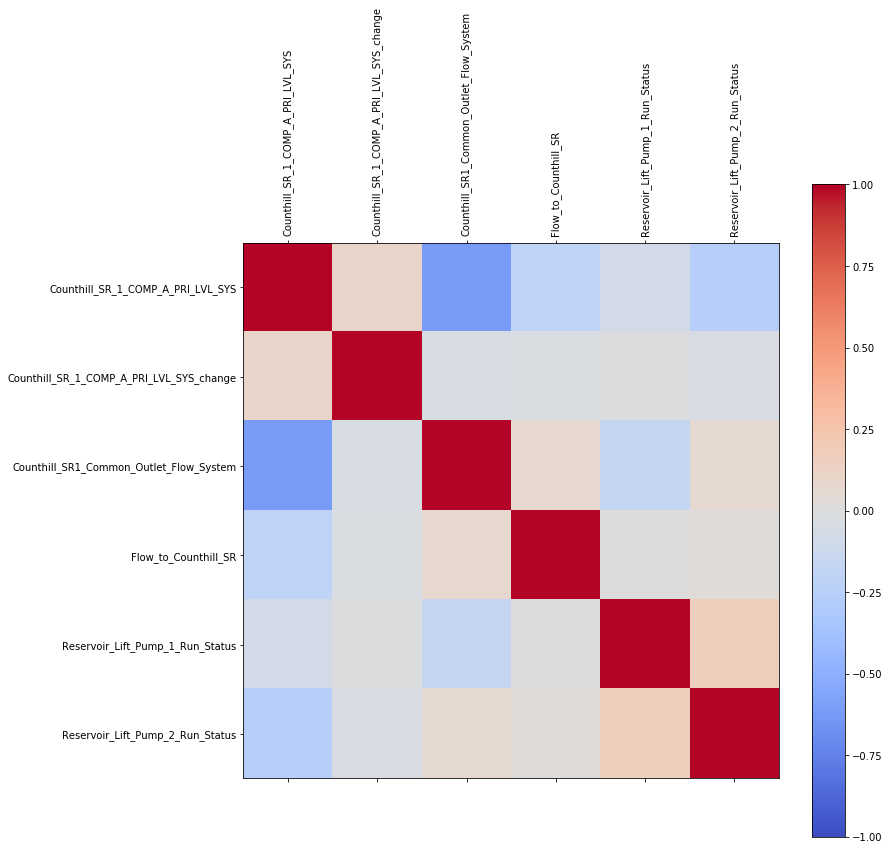

Counthill_SR_1_COMP_A_PRI_LVL_SYS           1.000000
Counthill_SR1_Common_Outlet_Flow_System    -0.614158
Reservoir_Lift_Pump_2_Run_Status           -0.261993
Flow_to_Counthill_SR                       -0.206011
Counthill_SR_1_COMP_A_PRI_LVL_SYS_change    0.101710
Reservoir_Lift_Pump_1_Run_Status           -0.075915
Name: Counthill_SR_1_COMP_A_PRI_LVL_SYS, dtype: float64
Counthill_SR_1_COMP_A_PRI_LVL_SYS_change    1.000000
Counthill_SR_1_COMP_A_PRI_LVL_SYS           0.101710
Counthill_SR1_Common_Outlet_Flow_System    -0.041071
Reservoir_Lift_Pump_2_Run_Status           -0.037132
Flow_to_Counthill_SR                       -0.026622
Reservoir_Lift_Pump_1_Run_Status           -0.009058
Name: Counthill_SR_1_COMP_A_PRI_LVL_SYS_change, dtype: float64


In [57]:
Counthill_col = [
    'Counthill_SR_1_COMP_A_PRI_LVL_SYS',
    'Counthill_SR_1_COMP_A_PRI_LVL_SYS_change',
     "Counthill_SR1_Common_Outlet_Flow_System", # demand flow
     "Flow_to_Counthill_SR", # demand flow
     "Reservoir_Lift_Pump_1_Run_Status",
     "Reservoir_Lift_Pump_2_Run_Status"
]

plot_correlation(oldham_sample[Counthill_col], 
                 ["Counthill_SR_1_COMP_A_PRI_LVL_SYS", "Counthill_SR_1_COMP_A_PRI_LVL_SYS_change"])



2. Reservoir level VS cyclic time, weather

In [63]:
timers = ['hr', 'month', 'dayofweek', 'dayofmonth', 'time']
cyclic_timer = edpf.CyclicTimeExtracter(timers=timers)

oldham_sample = cyclic_timer.transform(oldham_sample)

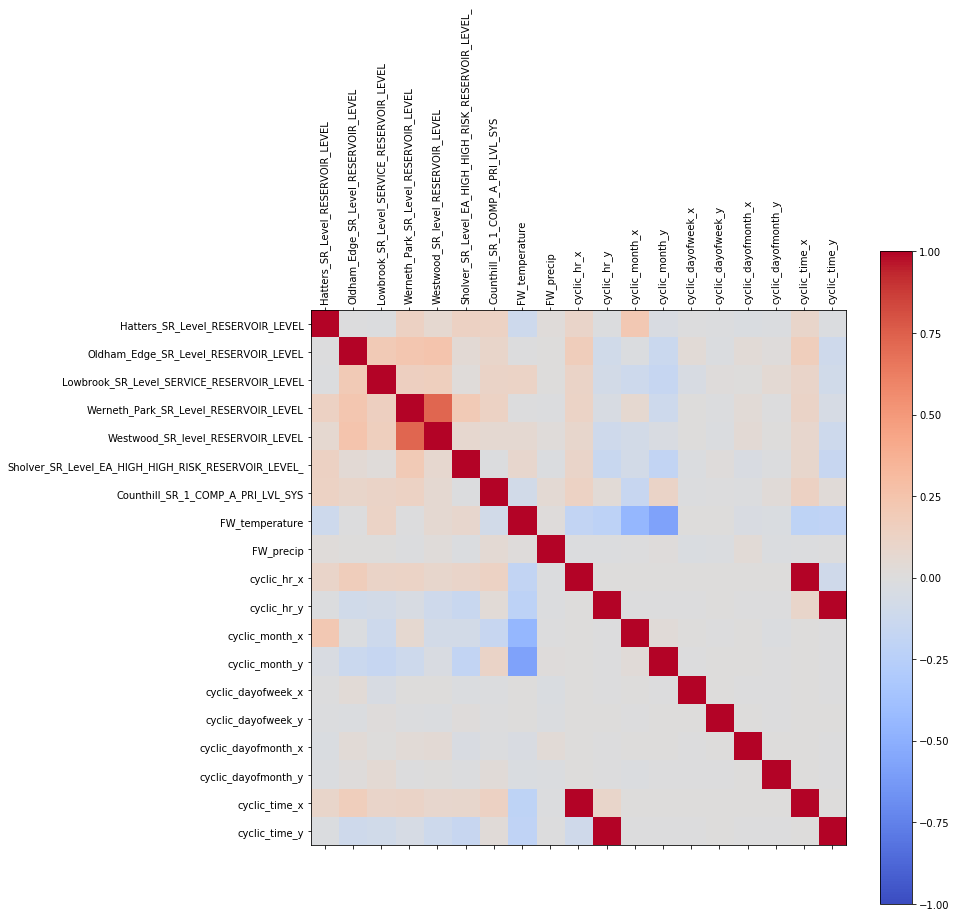

Hatters_SR_Level_RESERVOIR_LEVEL                       1.000000
cyclic_month_x                                         0.216284
Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL_    0.133474
Werneth_Park_SR_Level_RESERVOIR_LEVEL                  0.133347
Counthill_SR_1_COMP_A_PRI_LVL_SYS                      0.132560
FW_temperature                                        -0.112689
cyclic_hr_x                                            0.101811
cyclic_time_x                                          0.100317
Westwood_SR_level_RESERVOIR_LEVEL                      0.069721
cyclic_month_y                                        -0.033573
cyclic_dayofmonth_x                                   -0.026617
cyclic_time_y                                         -0.023033
cyclic_dayofmonth_y                                   -0.021734
FW_precip                                              0.017925
Lowbrook_SR_Level_SERVICE_RESERVOIR_LEVEL             -0.014185
cyclic_hr_y                             

In [65]:
time_weather_col = ['FW_temperature',
       'FW_precip', 'cyclic_hr_x', 'cyclic_hr_y', 'cyclic_month_x',
       'cyclic_month_y', 'cyclic_dayofweek_x', 'cyclic_dayofweek_y',
       'cyclic_dayofmonth_x', 'cyclic_dayofmonth_y', 'cyclic_time_x',
       'cyclic_time_y']

plot_correlation(oldham_sample[SRs+time_weather_col], SRs)



### Pumps + gravity


- Werneth Park SR: pumps run status, Westwood SR


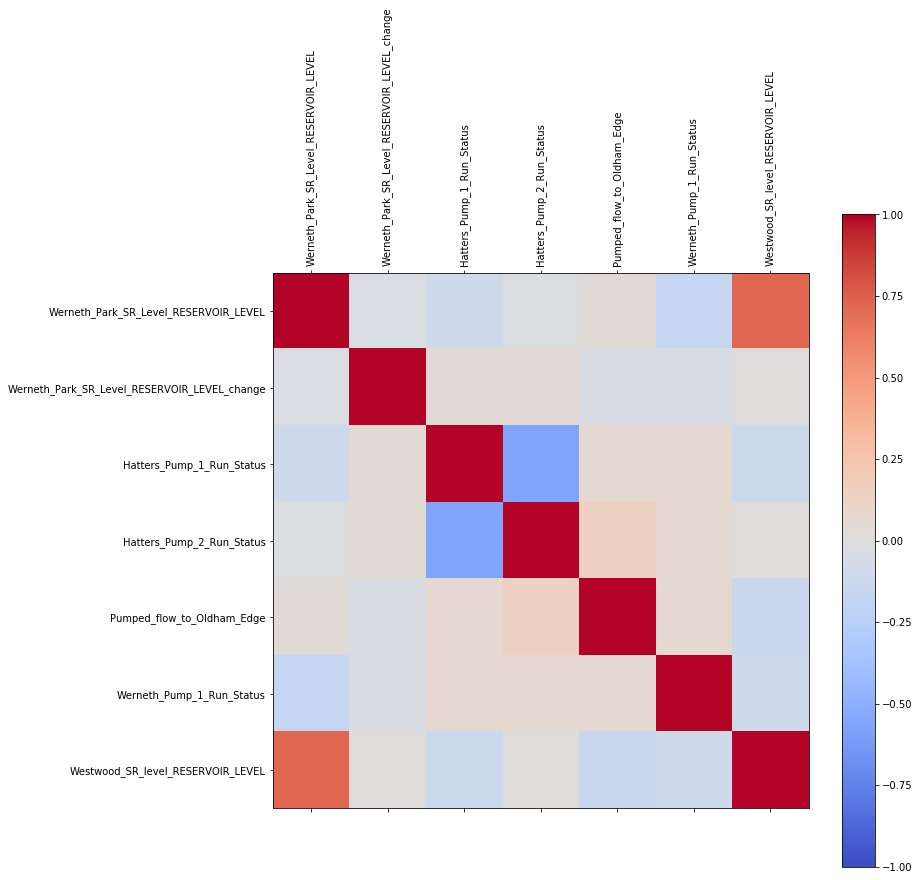

Werneth_Park_SR_Level_RESERVOIR_LEVEL           1.000000
Westwood_SR_level_RESERVOIR_LEVEL               0.725171
Werneth_Pump_1_Run_Status                      -0.168847
Hatters_Pump_1_Run_Status                      -0.103987
Werneth_Park_SR_Level_RESERVOIR_LEVEL_change   -0.025029
Pumped_flow_to_Oldham_Edge                      0.024078
Hatters_Pump_2_Run_Status                      -0.009128
Name: Werneth_Park_SR_Level_RESERVOIR_LEVEL, dtype: float64
Werneth_Park_SR_Level_RESERVOIR_LEVEL_change    1.000000
Hatters_Pump_2_Run_Status                       0.043652
Hatters_Pump_1_Run_Status                       0.042279
Pumped_flow_to_Oldham_Edge                     -0.038767
Werneth_Pump_1_Run_Status                      -0.034688
Werneth_Park_SR_Level_RESERVOIR_LEVEL          -0.025029
Westwood_SR_level_RESERVOIR_LEVEL               0.012989
Name: Werneth_Park_SR_Level_RESERVOIR_LEVEL_change, dtype: float64


In [66]:
Werneth_col = [
    "Werneth_Park_SR_Level_RESERVOIR_LEVEL",
    "Werneth_Park_SR_Level_RESERVOIR_LEVEL_change",
    "Hatters_Pump_1_Run_Status",
     "Hatters_Pump_2_Run_Status",
     "Pumped_flow_to_Oldham_Edge",
     "Werneth_Pump_1_Run_Status",
     "Westwood_SR_level_RESERVOIR_LEVEL"
]

plot_correlation(oldham_sample[Werneth_col], 
                 ["Werneth_Park_SR_Level_RESERVOIR_LEVEL", "Werneth_Park_SR_Level_RESERVOIR_LEVEL_change"])



## Macclesfield

### Pumps + demand

- knutsford_sr: demand, pump flows, lags
- hollins_sr: demand, pump flows, lags
- kerridge_sr: demand, pump flows
- hilltop_sr: demand, pump flows
- wilmslow_sr: demand, pump flows
- coppice_sr: demand, pump flows

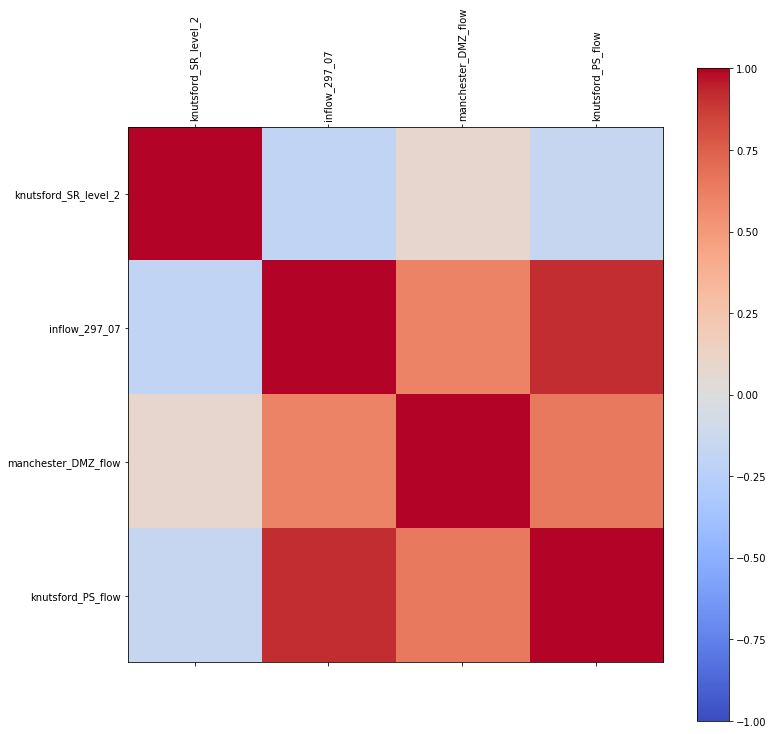

knutsford_SR_level_2    1.000000
inflow_297_07          -0.184118
knutsford_PS_flow      -0.150172
manchester_DMZ_flow     0.084474
Name: knutsford_SR_level_2, dtype: float64


In [119]:
Knutsford_col = [
    "knutsford_SR_level_2",
    "inflow_297_07", # demand
     "manchester_DMZ_flow", # demand + pump + lags
     "knutsford_PS_flow",
]

plot_correlation(mclf_sample[Knutsford_col], 
                 ["knutsford_SR_level_2"])


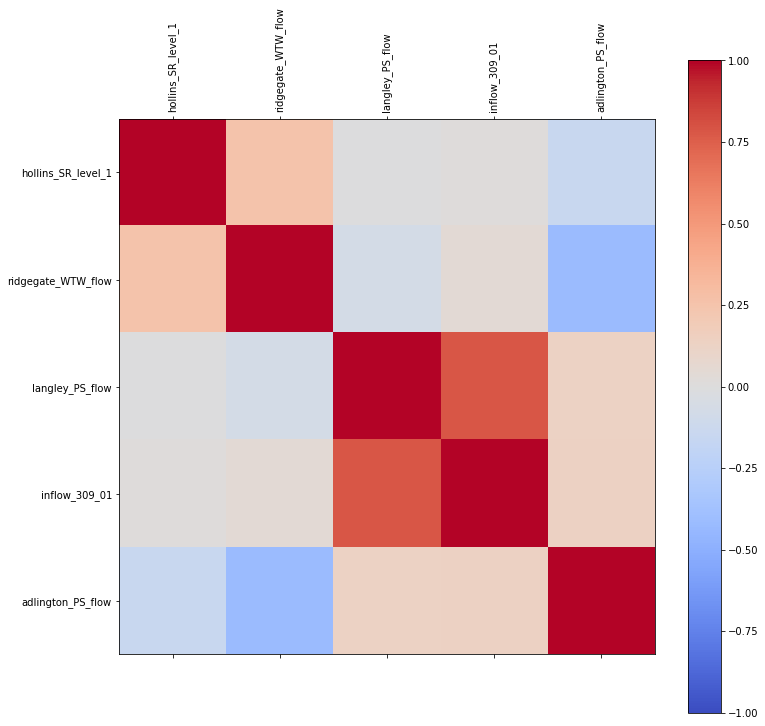

hollins_SR_level_1    1.000000
ridgegate_WTW_flow    0.257244
adlington_PS_flow    -0.147224
inflow_309_01         0.009296
langley_PS_flow      -0.004126
Name: hollins_SR_level_1, dtype: float64


In [120]:
Hollins_sr = [
    "hollins_SR_level_1",
    "ridgegate_WTW_flow", # demand
    "langley_PS_flow",
    "inflow_309_01", # demand
    "adlington_PS_flow"
]

plot_correlation(mclf_sample[Hollins_sr], 
                 ["hollins_SR_level_1"])


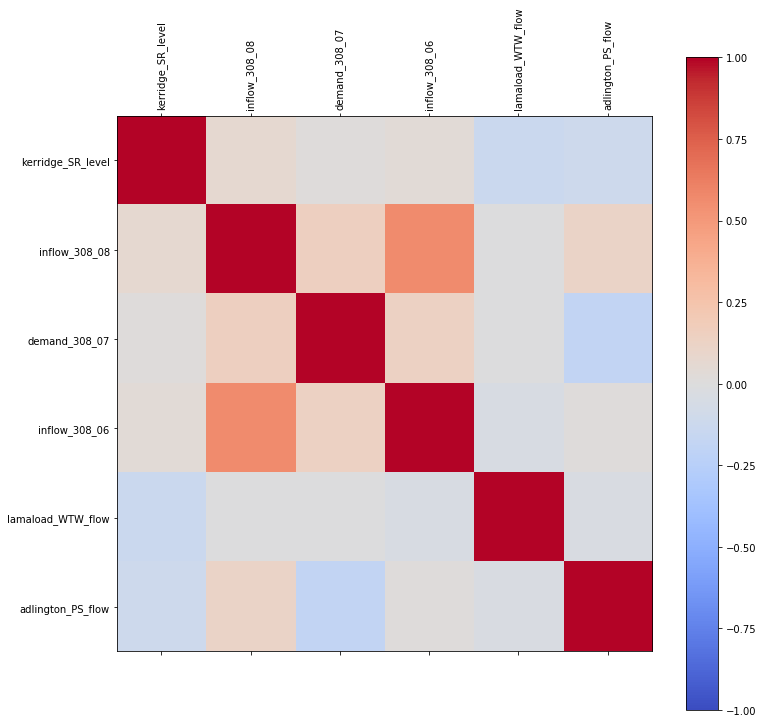

kerridge_SR_level    1.000000
lamaload_WTW_flow   -0.132060
adlington_PS_flow   -0.113387
inflow_308_08        0.064564
inflow_308_06        0.034700
demand_308_07        0.008309
Name: kerridge_SR_level, dtype: float64


In [121]:
kerridge_col = [
    "kerridge_SR_level",
    "inflow_308_08", # demand
    "demand_308_07", # demand
    "inflow_308_06", # demand
    "lamaload_WTW_flow", # demand
    "adlington_PS_flow"
]

plot_correlation(mclf_sample[kerridge_col], 
                 ["kerridge_SR_level"])



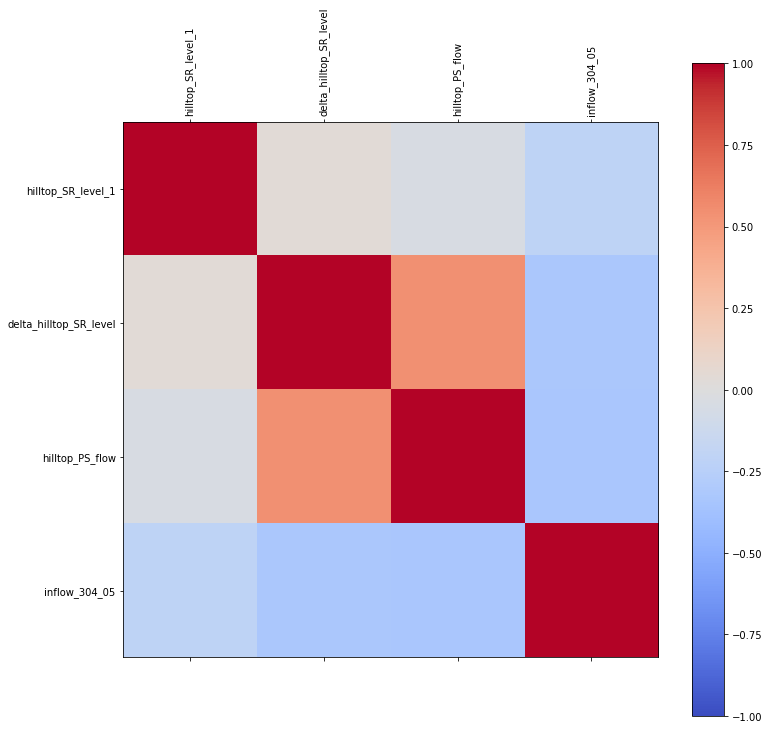

hilltop_SR_level_1        1.000000
inflow_304_05            -0.208309
hilltop_PS_flow          -0.044438
delta_hilltop_SR_level    0.036370
Name: hilltop_SR_level_1, dtype: float64
delta_hilltop_SR_level    1.000000
hilltop_PS_flow           0.543899
inflow_304_05            -0.326800
hilltop_SR_level_1        0.036370
Name: delta_hilltop_SR_level, dtype: float64


In [123]:
hilltop_col = [
    "hilltop_SR_level_1",
    "delta_hilltop_SR_level",
    "hilltop_PS_flow",
    "inflow_304_05"
]

plot_correlation(mclf_sample[hilltop_col], 
                 ["hilltop_SR_level_1", "delta_hilltop_SR_level"])



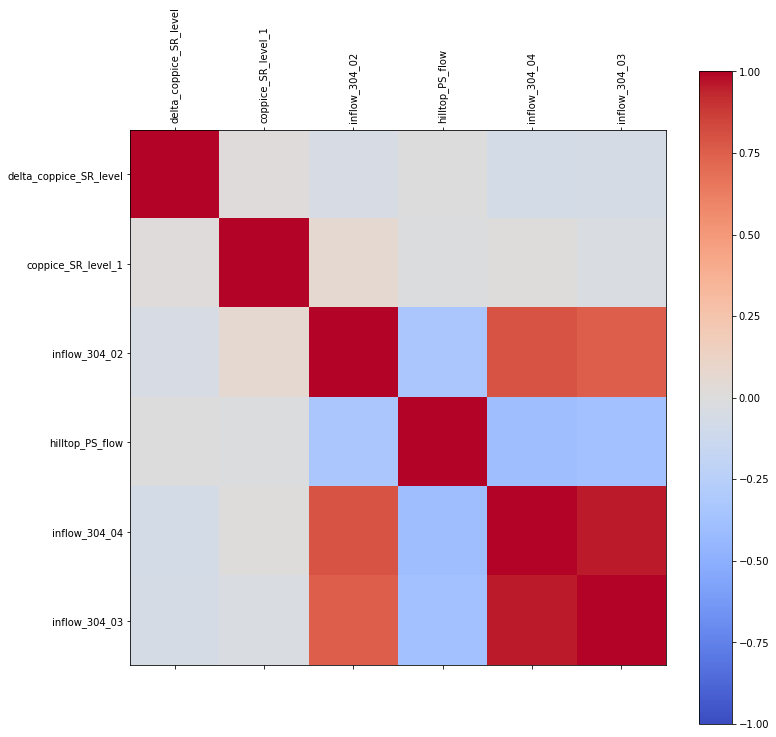

coppice_SR_level_1        1.000000
inflow_304_02             0.068976
inflow_304_03            -0.026726
hilltop_PS_flow          -0.015564
delta_coppice_SR_level    0.013356
inflow_304_04             0.004823
Name: coppice_SR_level_1, dtype: float64
delta_coppice_SR_level    1.000000
inflow_304_04            -0.063768
inflow_304_03            -0.055172
inflow_304_02            -0.047427
coppice_SR_level_1        0.013356
hilltop_PS_flow          -0.005652
Name: delta_coppice_SR_level, dtype: float64


In [125]:
coppice_col = [
    "delta_coppice_SR_level",
     "coppice_SR_level_1",
     "inflow_304_02",
     "hilltop_PS_flow",
     "inflow_304_04",
     "inflow_304_03"
]

plot_correlation(mclf_sample[coppice_col], 
                 ["coppice_SR_level_1", "delta_coppice_SR_level"])




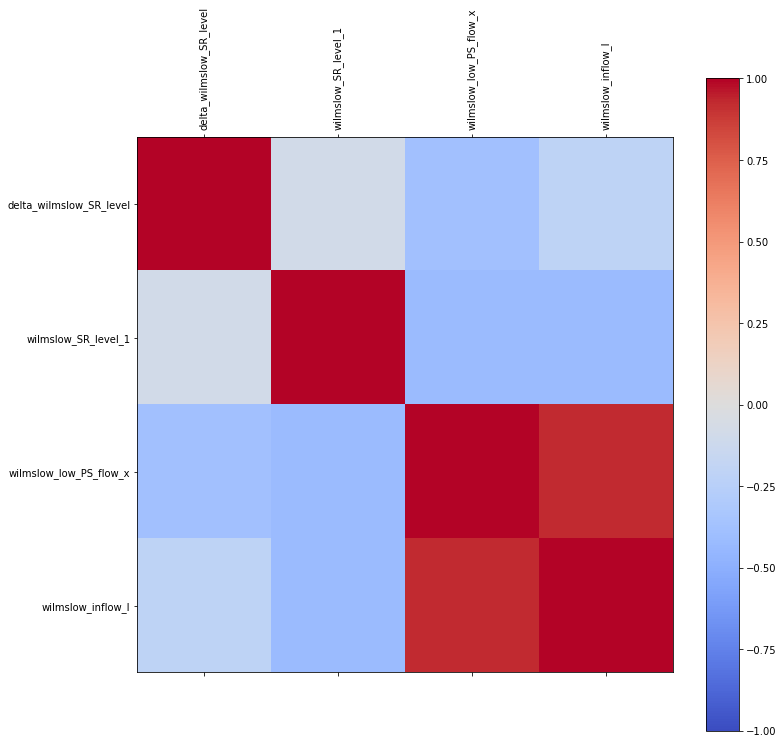

wilmslow_SR_level_1        1.000000
wilmslow_inflow_l         -0.420629
wilmslow_low_PS_flow_x    -0.419970
delta_wilmslow_SR_level   -0.082036
Name: wilmslow_SR_level_1, dtype: float64
delta_wilmslow_SR_level    1.000000
wilmslow_low_PS_flow_x    -0.376992
wilmslow_inflow_l         -0.208719
wilmslow_SR_level_1       -0.082036
Name: delta_wilmslow_SR_level, dtype: float64


In [124]:
wilmslow_col = [
    "delta_wilmslow_SR_level",
    "wilmslow_SR_level_1",
    "wilmslow_low_PS_flow_x",
    "wilmslow_inflow_l" # demand
]

plot_correlation(mclf_sample[wilmslow_col], 
                 ["wilmslow_SR_level_1", "delta_wilmslow_SR_level"])


### Pumps + gravity + demand

- hurdsfield_sr: demand, pump flows, kerridge_sr, lags


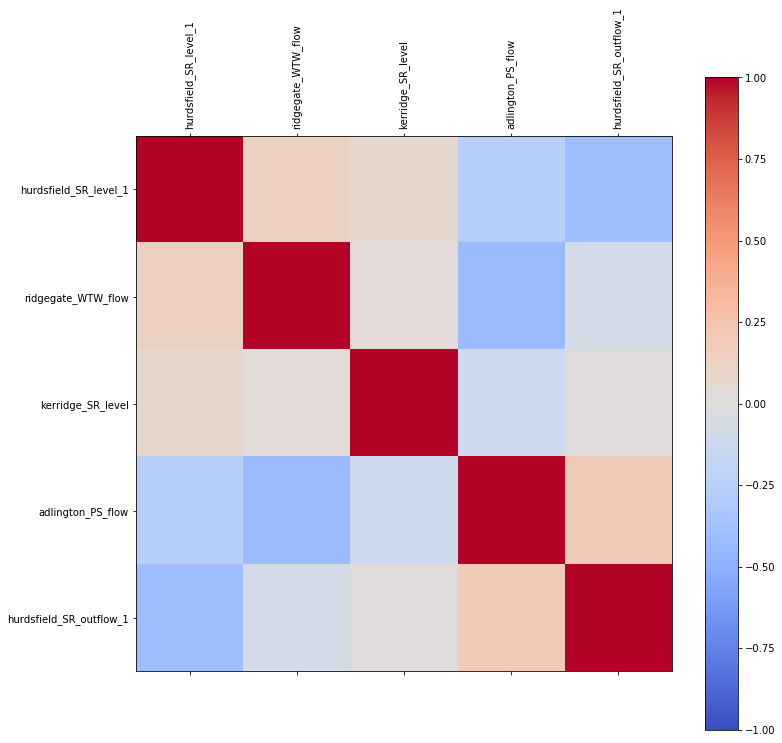

hurdsfield_SR_level_1      1.000000
hurdsfield_SR_outflow_1   -0.396733
adlington_PS_flow         -0.256917
ridgegate_WTW_flow         0.134400
kerridge_SR_level          0.085412
Name: hurdsfield_SR_level_1, dtype: float64


In [128]:
hurdsfield_col = [
    "hurdsfield_SR_level_1",
    "ridgegate_WTW_flow",
    "kerridge_SR_level", # gravity
    "adlington_PS_flow", 
    "hurdsfield_SR_outflow_1" # demand
]

plot_correlation(mclf_sample[hurdsfield_col], 
                 ["hurdsfield_SR_level_1"])



# Recipes

## Trial cases

### Demand

- demand flows, cyclic time -> reservoir_delta: oldham (Sholver_SR_Level_delta)

try with: cyclic time, weather -> reservoir_delta

### Pump & demand

1. inflow[1], outflow[1] -> reservoir_delta
    - Barrie: Maple_level_Change
2. inflow, outflow, pumps[2] -> reservoir_delta
    - Barrie: Harvie_level_Change
3. pumps, cyclic time, (weather) -> reservoir_delta
    - oldham: Hatters_SR_Level_delta, Westwood_SR_level_delta
4. pumps, demand flows -> reservoir_delta
    - oldham: Lowbrook_SR_Level_delta, Oldham_Edge_SR_Level_delta, Counthill_SR_1_LVL_delta
    - macclesfield: hilltop_sr_delta, wilmslow_sr_delta, coppice_sr_delta
5. pumps, pump lags, demand flows, demand flow lags -> reservoir
    - macclesfield: hollins_sr, kerridge_sr
6. pumps, pump lags, demand flow, demand flow lags, reservoir flow, reservoir flow lags -> reservoir
    - macclesfield: knutsford_sr


=-=-=-=-=-=

[1] reservoir flows (inflow or outflow):

    - pumps, cyclic time, weather -> 2 flows: Barrie
    - pumps, flow lags, cyclic time, weather -> 1 flow: Macclesfield, Barrie (harvie inflow)
    - pumps, flow lags -> 1 flow: Barrie (harvie outflow)


[2] pumps: pump run status, pump flow

[3] demand flow: 
    - cyclic time -> demand flow: oldham
    - cyclic time, weather -> demand flow: oldham
    - cyclic time, self lag -> demand flow: macclesfield
    - cyclic time, weather, self lag -> demand flow: macclesfield

try with: pumps, (pump lags), cyclic time, weather -> reservoir or reservoir_lag

### Pump & valve

- valve -> inflow, pump -> outflow: Barrie (Permeate_Reservoir_Level_Change)
    - upstream flow, valve -> inflow
    - pump run status -> pump flow (outflow)
    - inflow, outflow -> reservoir delta
    
try with: valve, pumps -> reservoir delta

### Pump & gravity

- pumps, gravity reservoir -> reservoir: oldham (Werneth_Park_SR_Level_RESERVOIR_LEVEL)
- pumps, pumps lags, gravity reservoir, gravity reservoir lags, demand, demand lags -> reservoir: macclesfield (hurdsfield_sr)

try with: pumps, gravity reservoir, cyclic time & weather -> reservoir

## Demand

### Oldham (Sholver_delta): orig = test

In [22]:
sholver_feat_cols = ['cyclic_hr_x', 'cyclic_hr_y', 'cyclic_month_x', 'cyclic_month_y', 'cyclic_dayofmonth_x',
                     'cyclic_dayofmonth_y', 'cyclic_dayofweek_x', 'cyclic_dayofweek_y', 
                     'Flow_to_Counthill_SR', # cyclic time, weather
                     'Buckstones_Road_Flow' # cyclic time, weather
                    ]

sholver_tar = ['Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL__change']

In [24]:
model_sholver = RandomForestRegressor(n_estimators = 60, 
                                      max_depth=20).fit(oldham_sample_train[sholver_feat_cols], 
                                                        oldham_sample_train[sholver_tar])


Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL_ mape (daily average): 9.566939319936374
Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL_ rmse (daily average): 0.5489991643542346


Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL_          
                                                 mape      rmse
0                                           9.566939   0.548999

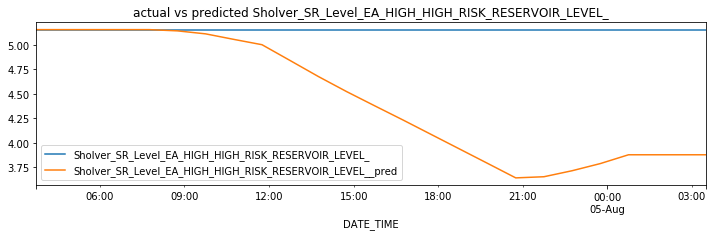

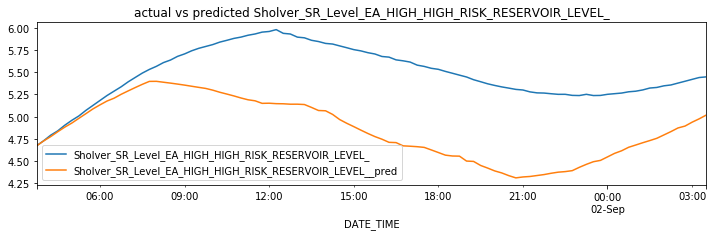

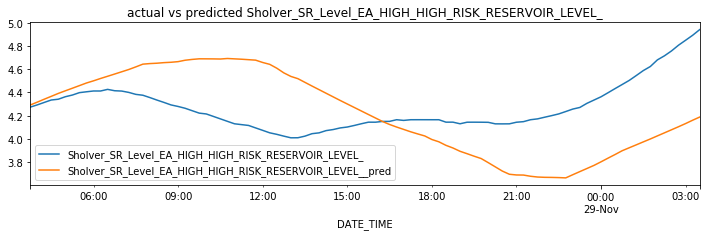

In [28]:
# orig model

emg_eval.evaluation_daily(oldham_sample_test, model_sholver, sholver_feat_cols, 
                    ['Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL_'], diff_type=True)


In [29]:
sholver_feat_cols_test = ['cyclic_hr_x', 'cyclic_hr_y', 'cyclic_month_x', 'cyclic_month_y', 'cyclic_dayofmonth_x',
                     'cyclic_dayofmonth_y', 'cyclic_dayofweek_x', 'cyclic_dayofweek_y', 'cyclic_time_x', 'cyclic_time_y',
                          'FW_temperature',]


model_sholver_test = RandomForestRegressor(n_estimators = 60, 
                                      max_depth=20).fit(oldham_sample_train[sholver_feat_cols_test], 
                                                        oldham_sample_train[sholver_tar])


Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL_ mape (daily average): 9.268505656292984
Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL_ rmse (daily average): 0.5319240659007197


Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL_          
                                                 mape      rmse
0                                           9.268506   0.531924

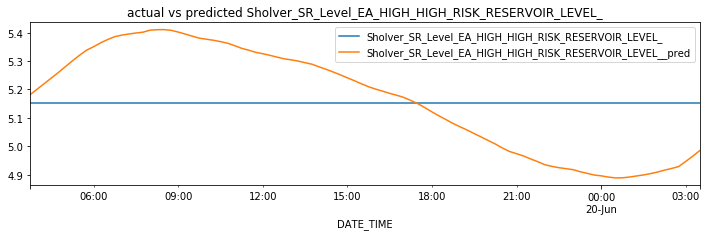

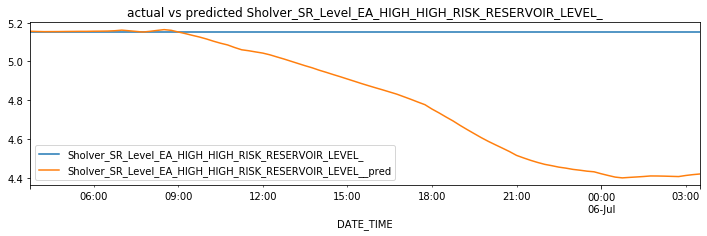

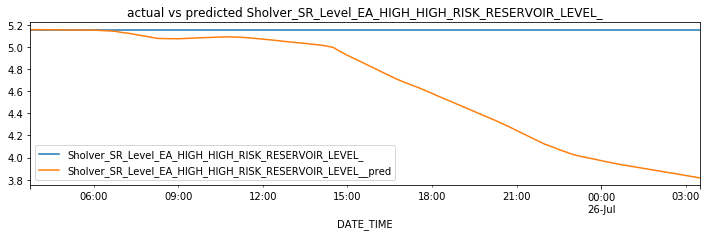

In [31]:
# test model

emg_eval.evaluation_daily(oldham_sample_test, model_sholver_test, sholver_feat_cols_test, 
                    ['Sholver_SR_Level_EA_HIGH_HIGH_RISK_RESERVOIR_LEVEL_'], diff_type=True)



## Pump & demand


### case #1: orig > test

In [29]:
maple_feat_cols = ['Maple_inlet_flow', 'Maple_outlet_flow']

model_maple = RandomForestRegressor(n_estimators = 60, 
                                      max_depth=20).fit(barrie_sample_train[maple_feat_cols], 
                                                        barrie_sample_train['Maple_level_delta'])


Maple_level mape (daily average): 4.850162898122732
Maple_level rmse (daily average): 0.7066002830375515


Maple_level        
         mape    rmse
0    4.850163  0.7066

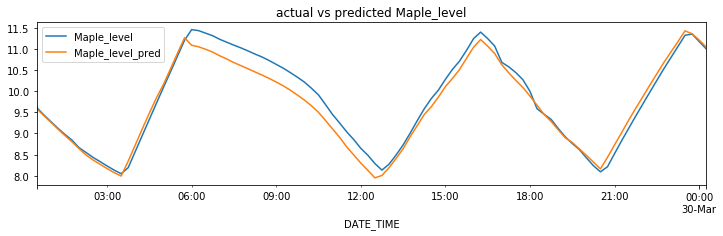

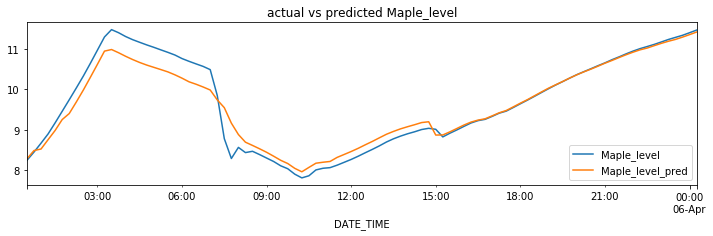

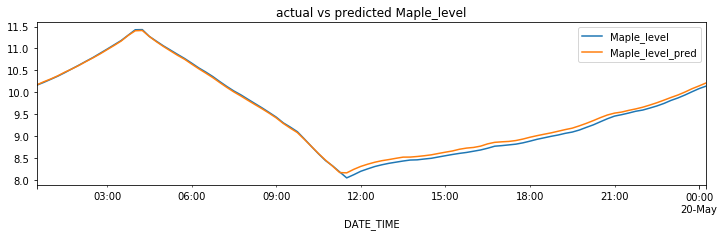

In [52]:
# orig model

emg_eval.evaluation_daily(barrie_sample_test, model_maple, maple_feat_cols, 
                    ['Maple_level'], diff_type=True)



In [31]:
maple_flow_feat_cols = ['Big_Bay_Flow', 'Harvie_booster_outlet_flow', 'Barrie_temperature', 'Barrie_precipitation',
                       'cyclic_hr_x', 'cyclic_hr_y', 'cyclic_month_x', 'cyclic_month_y', 'cyclic_dayofweek_x', 'cyclic_dayofweek_y', ]

model_maple_flow = RandomForestRegressor(n_estimators = 60, 
                                      max_depth=20).fit(barrie_sample_train[maple_flow_feat_cols], 
                                                        barrie_sample_train[maple_feat_cols])


Maple_level mape (daily average): 19.278699163747607
Maple_level rmse (daily average): 2.2789309514752043


Maple_level          
         mape      rmse
0   19.278699  2.278931

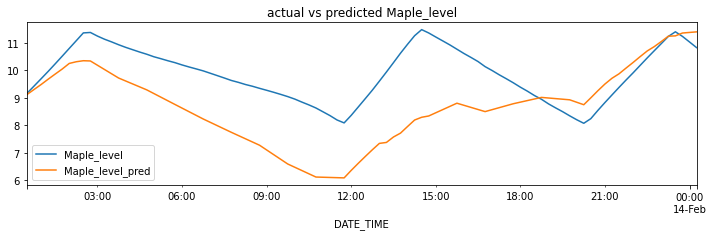

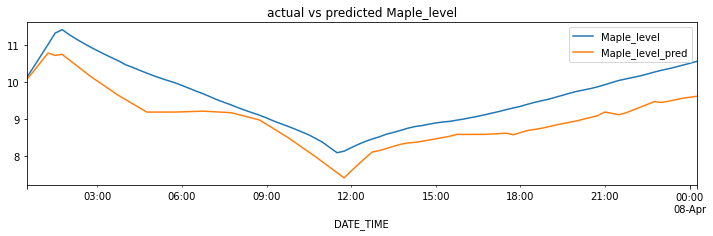

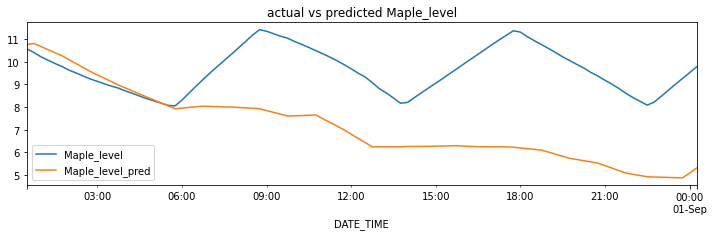

In [32]:
# pump -> flow -> reservoir

maple_flow_pred = model_maple_flow.predict(barrie_sample_test[maple_flow_feat_cols])

barrie_sample_test[maple_feat_cols] = maple_flow_pred

emg_eval.evaluation_daily(barrie_sample_test, model_maple, maple_feat_cols, 
                    ['Maple_level'], diff_type=True)



In [24]:
maple_feat_cols_test = ['Big_Bay_Flow', 'Harvie_booster_outlet_flow', 'Barrie_temperature', 'Barrie_precipitation',
                       'cyclic_hr_x', 'cyclic_hr_y', 'cyclic_month_x', 'cyclic_month_y', 'cyclic_dayofweek_x', 'cyclic_dayofweek_y', ]

model_maple_test = RandomForestRegressor(n_estimators = 60, 
                                      max_depth=20).fit(barrie_sample_train[maple_feat_cols_test], 
                                                        barrie_sample_train['Maple_level_delta'])



Maple_level mape (daily average): 17.780721169177554
Maple_level rmse (daily average): 1.9931404988810086


Maple_level         
         mape     rmse
0   17.780721  1.99314

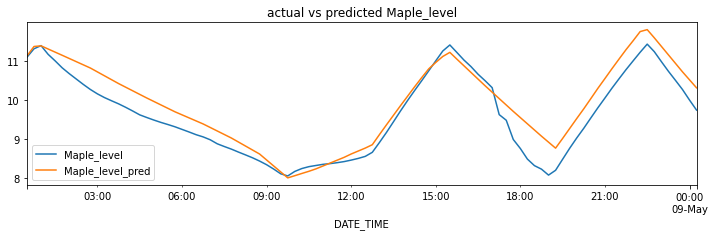

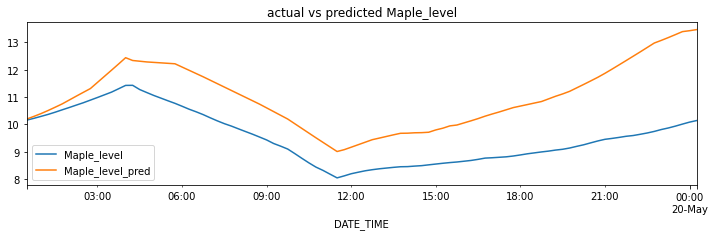

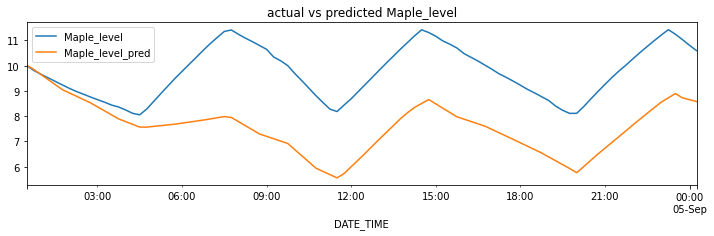

In [25]:
# test model

emg_eval.evaluation_daily(barrie_sample_test, model_maple_test, maple_feat_cols_test, 
                    ['Maple_level'], diff_type=True)



### Case #2: orig < test, but orig shows trend and test doesn't

In [27]:
harvie_feat_cols = ['Harvie_reservoir_inlet', 'Harvie_outlet_flow_1', 'Big_Bay_Flow', 'Harvie_booster_outlet_flow']

model_harvie = RandomForestRegressor(n_estimators = 60, 
                                      max_depth=20).fit(barrie_sample_train[harvie_feat_cols], 
                                                        barrie_sample_train['Harvie_reservoir_level_delta'])


Harvie_reservoir_level mape (daily average): 11.244925380051946
Harvie_reservoir_level rmse (daily average): 0.5907482860547103


Harvie_reservoir_level          
                    mape      rmse
0              11.244925  0.590748

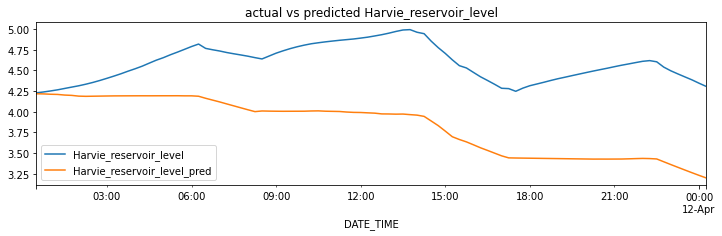

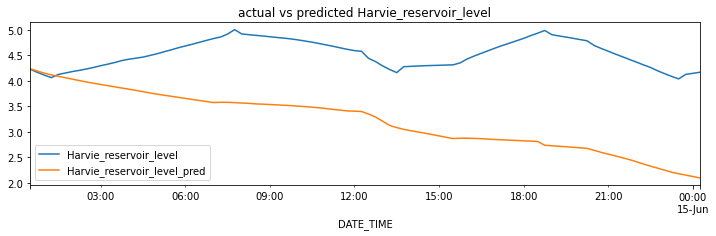

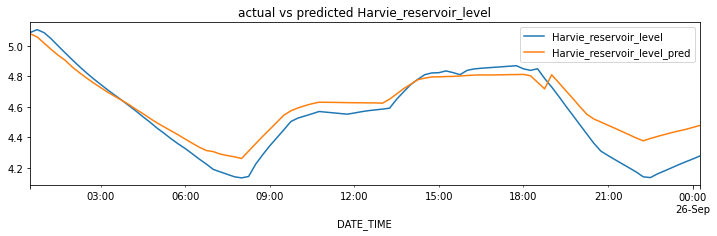

In [28]:
# orig model

emg_eval.evaluation_daily(barrie_sample_test, model_harvie, harvie_feat_cols, 
                    ['Harvie_reservoir_level'], diff_type=True)



In [102]:
harvie_feat_cols_test = ['Big_Bay_Flow', 'Harvie_booster_outlet_flow', 'HL_discharge_header1_flow', 'Barrie_temperature', 
                         'cyclic_hr_x', 'cyclic_hr_y', 'cyclic_month_x', 'cyclic_month_y', ]

model_harvie_test = RandomForestRegressor(n_estimators = 60, 
                                      max_depth=20).fit(barrie_sample_train[harvie_feat_cols_test], 
                                                        barrie_sample_train['Harvie_reservoir_level_delta'])



Harvie_reservoir_level mape (daily average): 9.00659910009028
Harvie_reservoir_level rmse (daily average): 0.5049896340075324


Harvie_reservoir_level         
                    mape     rmse
0               9.006599  0.50499

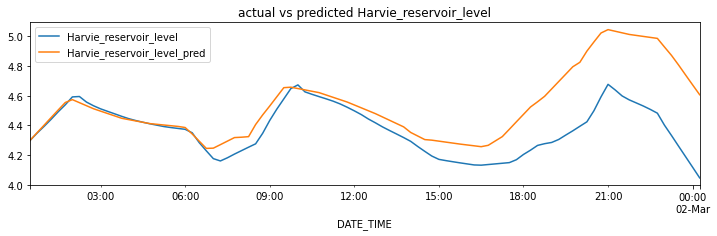

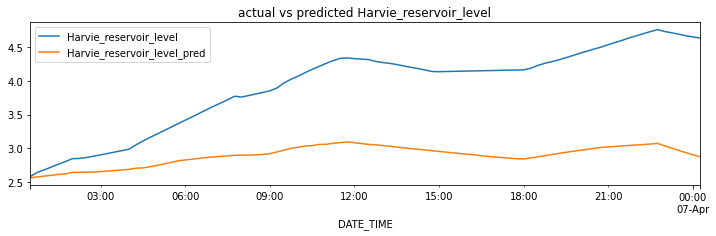

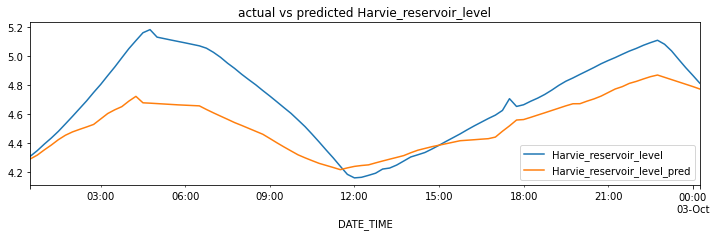

In [103]:
# test model

emg_eval.evaluation_daily(barrie_sample_test, model_harvie_test, harvie_feat_cols_test, 
                    ['Harvie_reservoir_level'], diff_type=True)



In [106]:
harvie_feat_cols3 = ['Harvie_reservoir_inlet', 'Harvie_outlet_flow_1']

model_harvie3 = RandomForestRegressor(n_estimators = 60, 
                                      max_depth=20).fit(barrie_sample_train[harvie_feat_cols3], 
                                                        barrie_sample_train['Harvie_reservoir_level_delta'])


Harvie_reservoir_level mape (daily average): 11.726961859710935
Harvie_reservoir_level rmse (daily average): 0.6054586899148229


Harvie_reservoir_level          
                    mape      rmse
0              11.726962  0.605459

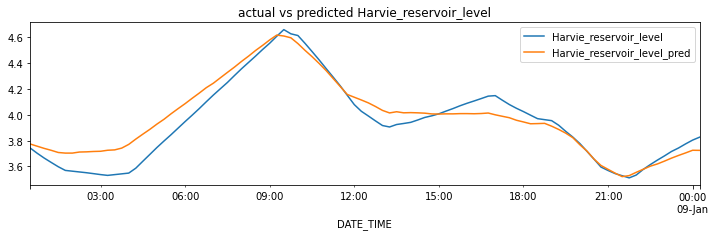

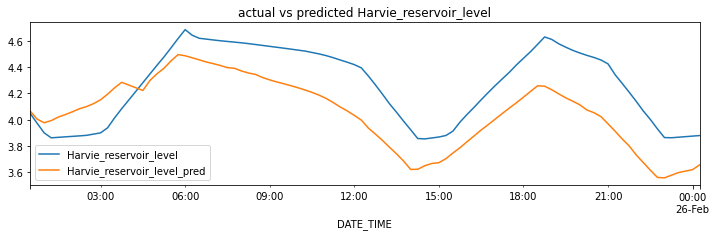

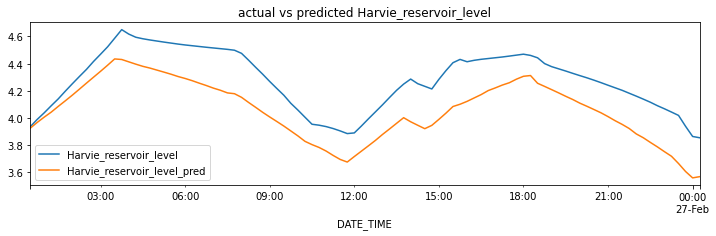

In [107]:
# test model 2

emg_eval.evaluation_daily(barrie_sample_test, model_harvie3, harvie_feat_cols3, 
                    ['Harvie_reservoir_level'], diff_type=True)


### case #3: Westwood_SR_level_delta

In [43]:
westwood_sr_feat = ['Hatters_Pump_1_Run_Status', "Hatters_Pump_2_Run_Status", "Pumped_flow_to_Oldham_Edge",
                    "Werneth_Pump_1_Run_Status", "FW_temperature", "FW_precip", 'cyclic_hr_x', 'cyclic_hr_y', 
                       'cyclic_month_x', 'cyclic_month_y', 'cyclic_dayofmonth_x', 'cyclic_dayofmonth_y', 
                       'cyclic_dayofweek_x', 'cyclic_dayofweek_y', ]


model_westwood_sr = RandomForestRegressor(n_estimators = 60, 
                                      max_depth=20).fit(oldham_sample_train[westwood_sr_feat], 
                                                        oldham_sample_train['Westwood_SR_level_RESERVOIR_LEVEL_change'])


Westwood_SR_level_RESERVOIR_LEVEL mape (daily average): 5.320322763610772
Westwood_SR_level_RESERVOIR_LEVEL rmse (daily average): 0.31537149548247945


Westwood_SR_level_RESERVOIR_LEVEL          
                               mape      rmse
0                          5.320323  0.315371

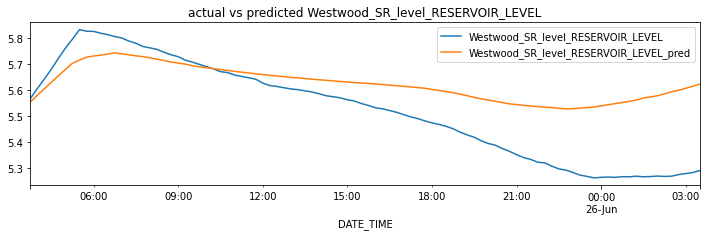

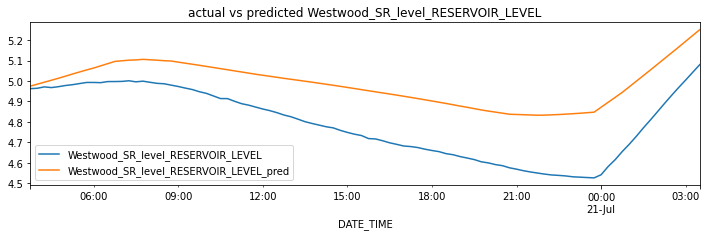

In [45]:

emg_eval.evaluation_daily(oldham_sample_test[:'2019-09-01 00:00:00'], model_westwood_sr, westwood_sr_feat, 
                    ['Westwood_SR_level_RESERVOIR_LEVEL'], diff_type=True)



### case #4: Oldham_Edge_SR_Level_delta: orig > test

In [43]:
oldham_sr_feat = ['Westwood_Pump_1_Run_Status', 'Westwood_Pump_2_Run_Status', 'Oldham_Oulet_Flowrate']


model_oldham_sr = RandomForestRegressor(n_estimators = 60, 
                                      max_depth=20).fit(oldham_sample_train[oldham_sr_feat], 
                                                        oldham_sample_train['Oldham_Edge_SR_Level_RESERVOIR_LEVEL_change'])



Oldham_Edge_SR_Level_RESERVOIR_LEVEL mape (daily average): 5.125916932140655
Oldham_Edge_SR_Level_RESERVOIR_LEVEL rmse (daily average): 0.326724608346571


Oldham_Edge_SR_Level_RESERVOIR_LEVEL          
                                  mape      rmse
0                             5.125917  0.326725

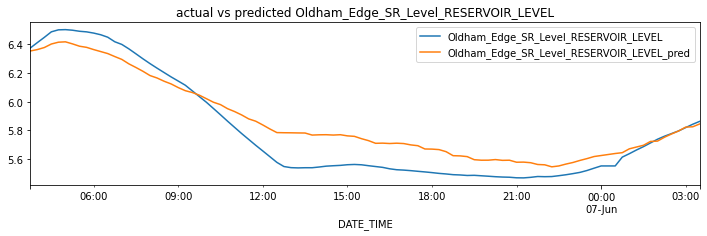

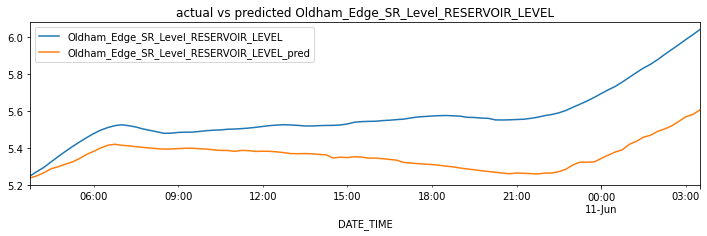

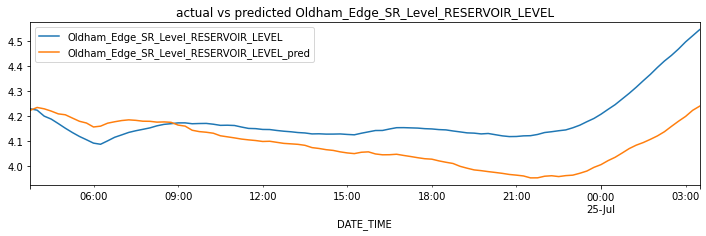

In [40]:
# orig model

emg_eval.evaluation_daily(oldham_sample_test[:'2019-09-01 00:00:00'], model_oldham_sr, oldham_sr_feat, 
                    ['Oldham_Edge_SR_Level_RESERVOIR_LEVEL'], diff_type=True)



In [42]:
oldham_sr_feat_test = ['Westwood_Pump_1_Run_Status', 'Westwood_Pump_2_Run_Status', 'cyclic_hr_x', 'cyclic_hr_y', 
                       'cyclic_month_x', 'cyclic_month_y', 'cyclic_dayofmonth_x', 'cyclic_dayofmonth_y', 
                       'cyclic_dayofweek_x', 'cyclic_dayofweek_y', "FW_temperature", "FW_precip"]


model_oldham_sr_test = RandomForestRegressor(n_estimators = 60, 
                                      max_depth=20).fit(oldham_sample_train[oldham_sr_feat_test], 
                                                        oldham_sample_train['Oldham_Edge_SR_Level_RESERVOIR_LEVEL_change'])



Oldham_Edge_SR_Level_RESERVOIR_LEVEL mape (daily average): 8.571376435865387
Oldham_Edge_SR_Level_RESERVOIR_LEVEL rmse (daily average): 0.5484565756270997


Oldham_Edge_SR_Level_RESERVOIR_LEVEL          
                                  mape      rmse
0                             8.571376  0.548457

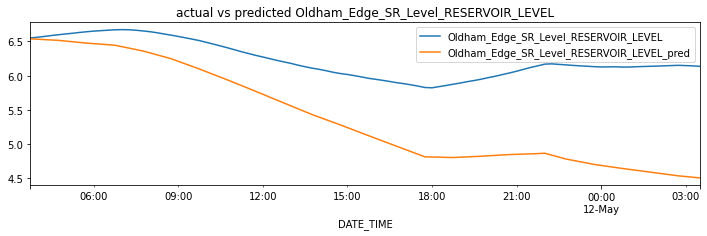

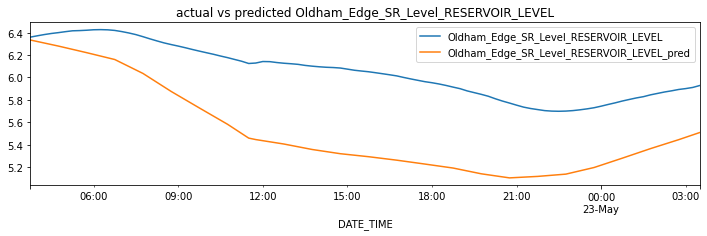

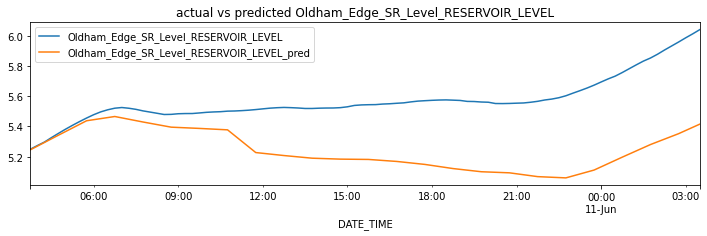

In [44]:
# test model

emg_eval.evaluation_daily(oldham_sample_test[:'2019-09-01 00:00:00'], model_oldham_sr_test, oldham_sr_feat_test, 
                    ['Oldham_Edge_SR_Level_RESERVOIR_LEVEL'], diff_type=True)




### case #5: orig > test

In [90]:
kerridge_df= mclf_sample.copy()

kerridge_feat = ['demand_308_07', 'inflow_308_08', 'lamaload_WTW_flow', 'inflow_308_06', 'adlington_PS_flow']


tar_cols = ['kerridge_SR_level']

kerridge_df1 = kerridge_df[kerridge_feat]


lag_creater2 = edpf.LagCreater(lags = [0,-2,-4,-6,-8,-10,-12])

for col in kerridge_feat:
    kerridge_df1 = lag_creater2.transform(kerridge_df1, col=col)

kerridge_df1[tar_cols] = mclf_sample[tar_cols]

In [91]:

kerridge_df1= kerridge_df1.dropna()

kerridge_df1_train, kerridge_df1_test = train_test_split_ts(kerridge_df1)

kerridge_feat = [col for col in kerridge_df1.columns if col not in tar_cols]


In [92]:
model_kerridge = RandomForestRegressor(n_estimators = 60, 
                                      max_depth=20).fit(kerridge_df1_train[kerridge_feat], 
                                                        kerridge_df1_train[tar_cols])


kerridge_SR_level mape (daily average): 18.048907007236036
kerridge_SR_level rmse (daily average): 0.5925840465206471


kerridge_SR_level          
               mape      rmse
0         18.048907  0.592584

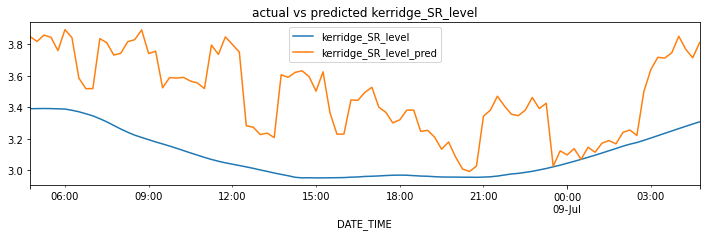

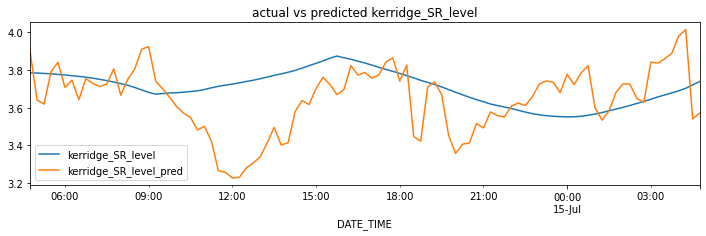

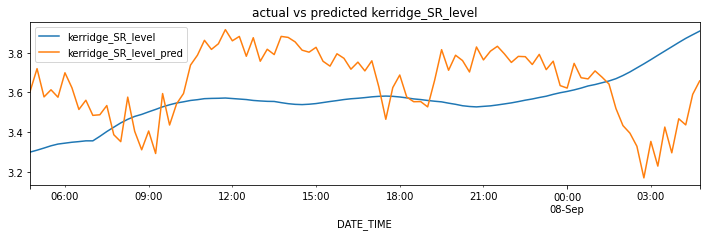

In [93]:
# orig model

emg_eval.evaluation_daily(kerridge_df1_test, model_kerridge, kerridge_feat, 
                    tar_cols, diff_type=False)


In [94]:
kerridge_feat2 = ['adlington_PS_flow', "FW_temperature", 'cyclic_hr_x', 'cyclic_hr_y', 
             'cyclic_min_x', 'cyclic_min_y', 'cyclic_dayofmonth_x', 'cyclic_dayofmonth_y', 'cyclic_dayofweek_x', 
             'cyclic_dayofweek_y', 'cyclic_month_x', 'cyclic_month_y']



kerridge_df2 = kerridge_df[kerridge_feat2]


kerridge_df2 = lag_creater2.transform(kerridge_df2, col='adlington_PS_flow')

kerridge_df2[tar_cols] = mclf_sample[tar_cols]

In [95]:
kerridge_df2= kerridge_df2.dropna()

kerridge_df2_train, kerridge_df2_test = train_test_split_ts(kerridge_df2)

kerridge_feat2 = [col for col in kerridge_df2.columns if col not in tar_cols]


In [96]:
model_kerridge2 = RandomForestRegressor(n_estimators = 60, 
                                      max_depth=20).fit(kerridge_df2_train[kerridge_feat2], 
                                                        kerridge_df2_train[tar_cols])


kerridge_SR_level mape (daily average): 20.78818006799102
kerridge_SR_level rmse (daily average): 0.671502502186452


kerridge_SR_level          
               mape      rmse
0          20.78818  0.671503

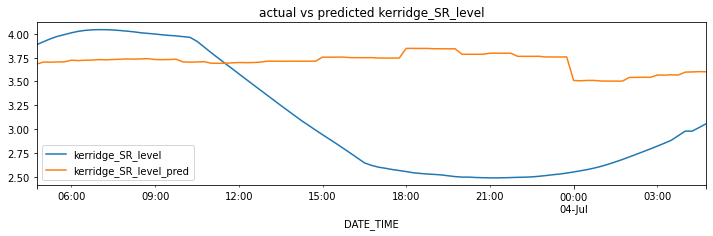

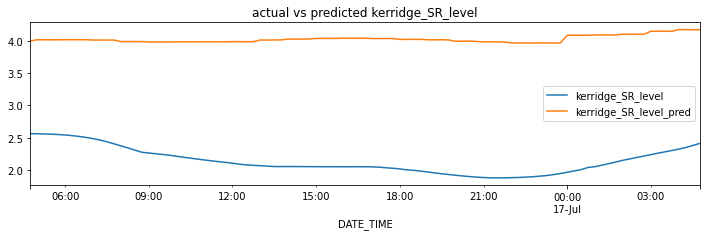

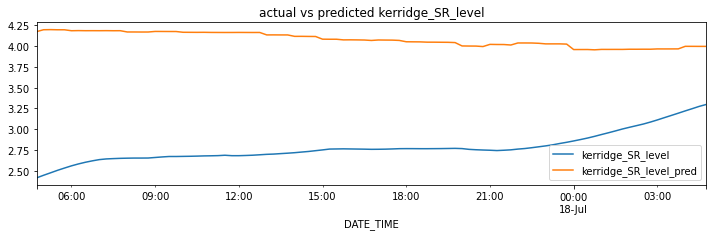

In [97]:
# test model

emg_eval.evaluation_daily(kerridge_df2_test, model_kerridge2, kerridge_feat2, 
                    tar_cols, diff_type=False)


### reservoir as target case #6

In [33]:
knutsford_df = mclf_sample.copy()


In [34]:
tar_cols = ['knutsford_SR_level_2']

feat_cols = ['inflow_297_07', 'manchester_DMZ_flow', 'knutsford_PS_flow']

knutsford_df1 = knutsford_df[feat_cols]

lag_creater = edpf.LagCreater(lags = [0, -1,-2,-3,-4,-5,-6,-7,-8,-9,-10])
for ff in feat_cols:
    knutsford_df1 = lag_creater.transform(knutsford_df1, col=ff)

    
knutsford_df1[tar_cols] = knutsford_df[tar_cols]

In [35]:
feat_cols = [col for col in knutsford_df1.columns if col not in tar_cols]

In [36]:
knutsford_df1 = knutsford_df1.dropna()

In [37]:
knutsford_df1_train, knutsford_df1_test = train_test_split_ts(knutsford_df1)


In [38]:
regr = RandomForestRegressor(n_estimators = 60, max_depth=20)
model1 = regr.fit(knutsford_df1_train[feat_cols], knutsford_df1_train[tar_cols])


In [39]:
pred = model1.predict(knutsford_df1_test['2019-08-10':'2019-08-12'][feat_cols])

knutsford_SR_level_2 mape: 1.4058025190755028
knutsford_SR_level_2 rmse: 0.04617409057834936


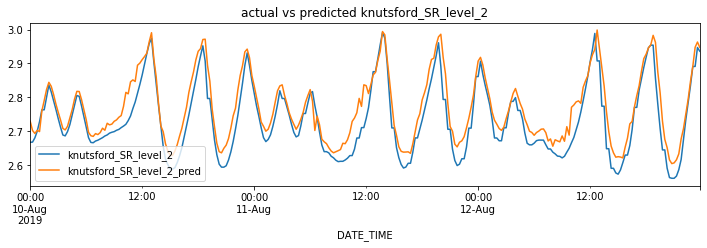

In [40]:
# orig res
emg_eval.show_evaluation_result(knutsford_df1_test['2019-08-10':'2019-08-12'][tar_cols], pred)


In [41]:
tar_cols = ['knutsford_SR_level_2']

feat_cols = ['knutsford_PS_flow', 'cyclic_time_x', 'cyclic_time_y', 'cyclic_hr_x', 'cyclic_hr_y', 
             'cyclic_min_x', 'cyclic_min_y', 'cyclic_dayofmonth_x', 'cyclic_dayofmonth_y', 'cyclic_dayofweek_x', 
             'cyclic_dayofweek_y', 'cyclic_month_x', 'cyclic_month_y', 'FW_precip', 'FW_temperature']

knutsford_df2 = knutsford_df[feat_cols]

knutsford_df2 = lag_creater.transform(knutsford_df2, col='knutsford_PS_flow')

knutsford_df2[tar_cols] = knutsford_df[tar_cols]

In [42]:
feat_cols = [col for col in knutsford_df2.columns if col not in tar_cols]

In [43]:
knutsford_df2 = knutsford_df2.dropna()

In [44]:
knutsford_df2_train, knutsford_df2_test = train_test_split_ts(knutsford_df2)


In [45]:
regr = RandomForestRegressor(n_estimators = 60, max_depth=20)
model2 = regr.fit(knutsford_df2_train[feat_cols], knutsford_df2_train[tar_cols])


In [46]:
pred2 = model2.predict(knutsford_df2_test['2019-08-10':'2019-08-12'][feat_cols])

knutsford_SR_level_2 mape: 2.8810582217222116
knutsford_SR_level_2 rmse: 0.09660060770396954


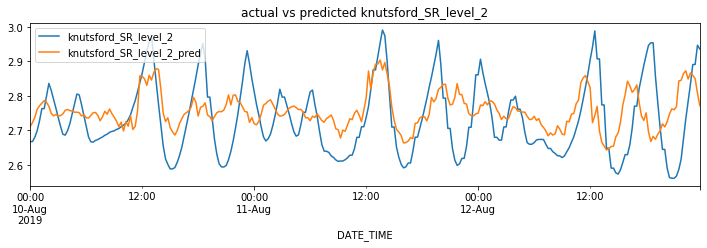

In [47]:
# test result

emg_eval.show_evaluation_result(knutsford_df2_test['2019-08-10':'2019-08-12'][tar_cols], pred2)



## Pump & valve: orig < test

In [12]:
permeate_feat = ['CCT1_inlet_flow', 'HL_discharge_header1_flow']

model_permeate = RandomForestRegressor(n_estimators = 60, 
                                      max_depth=20).fit(barrie_sample_train[permeate_feat], 
                                                        barrie_sample_train['Reservoir1_level_delta'])


Reservoir1_level mape (daily average): 1527.8677058107096
Reservoir1_level rmse (daily average): 0.7188473125947477


Reservoir1_level          
              mape      rmse
0      1527.867706  0.718847

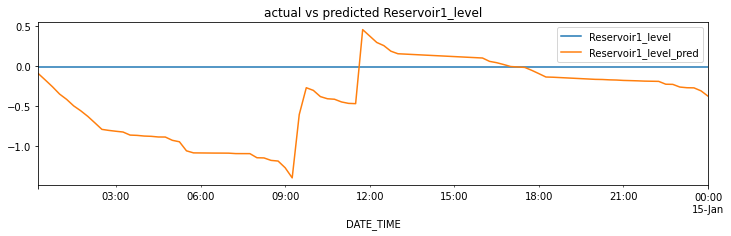

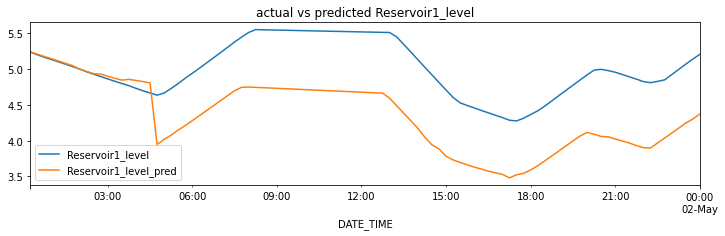

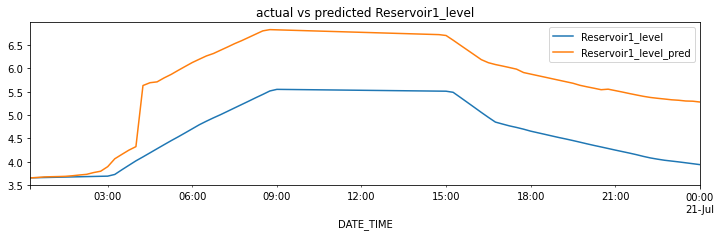

In [13]:
# orig model

emg_eval.evaluation_daily(barrie_sample_test, model_permeate, permeate_feat, 
                    ['Reservoir1_level'], diff_type=True)



In [71]:
cct_feat_cols = ['Total_GAC_flow', 'CCT1_valve_position', 'CCT2_valve_position']

model_cct = RandomForestRegressor(n_estimators = 60, 
                                      max_depth=20).fit(barrie_sample_train[cct_feat_cols], 
                                                        barrie_sample_train[['CCT1_inlet_flow', 'CCT2_inlet_flow']])

barrie_sample_test[['CCT1_inlet_flow', 'CCT2_inlet_flow']] = model_cct.predict(barrie_sample_test[cct_feat_cols])


Reservoir1_level mape (daily average): 1485.7058526758308
Reservoir1_level rmse (daily average): 0.686109653812233


Reservoir1_level         
              mape     rmse
0      1485.705853  0.68611

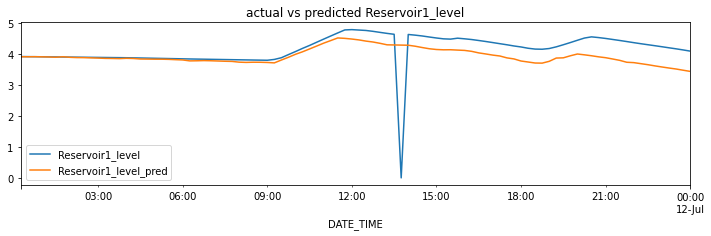

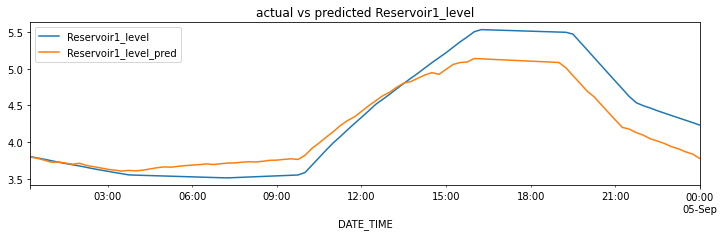

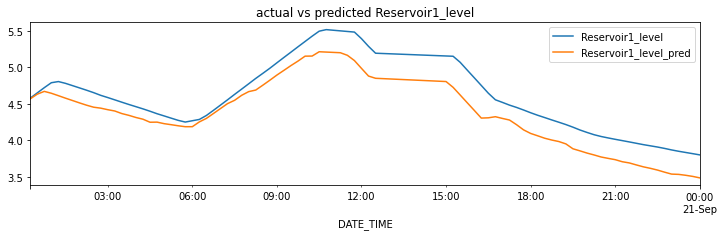

In [72]:
# Valve -> CCT -> reservoir

emg_eval.evaluation_daily(barrie_sample_test, model_permeate, permeate_feat, 
                    ['Reservoir1_level'], diff_type=True)


In [26]:
permeate_feat_test = ["Total_GAC_flow", "CCT1_valve_position", 'HL_discharge_header1_flow']

model_permeate_test = RandomForestRegressor(n_estimators = 60, 
                                      max_depth=20).fit(barrie_sample_train[permeate_feat_test], 
                                                        barrie_sample_train['Reservoir1_level_delta'])


Reservoir1_level rmse (daily average): 0.41846219488603803


Reservoir1_level
              rmse
0         0.418462

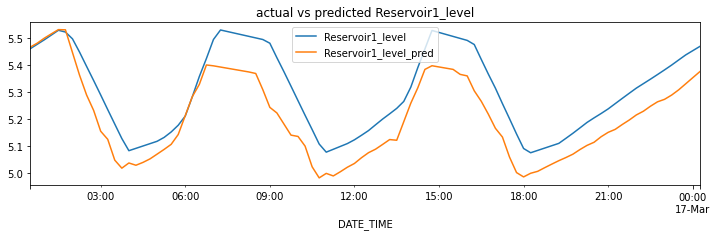

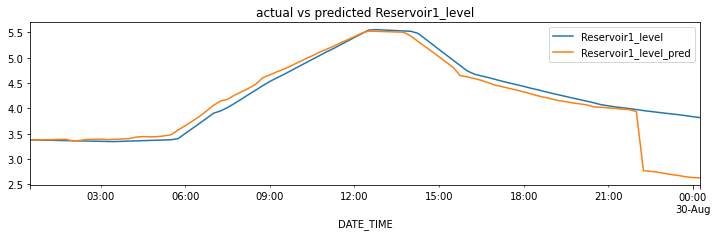

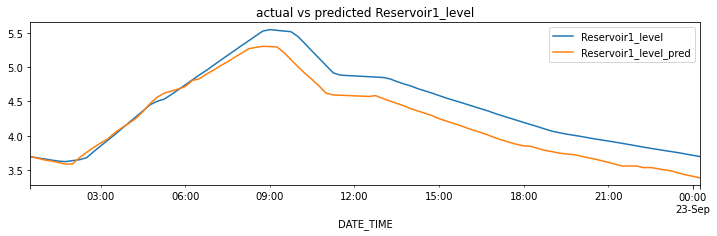

In [27]:
# test model

emg_eval.evaluation_daily(barrie_sample_test, model_permeate_test, permeate_feat_test, 
                    ['Reservoir1_level'], diff_type=True, metric_types=['rmse'])


### debugging evaluation metrics

Reservoir1_level mape (daily average): 7297.480822393136
Reservoir1_level rmse (daily average): 1.071737516801083


Reservoir1_level          
              mape      rmse
0      7297.480822  1.071738

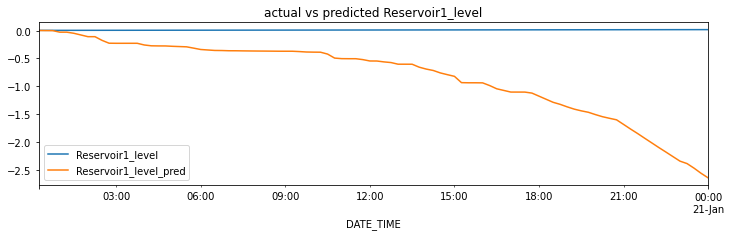

In [87]:
# 2019-02-07, 2019-01-20 -- mape are large

emg_eval.evaluation_daily(barrie_sample_test['2019-01-20 00:00:00':'2019-01-21 00:00:00'], model_permeate, permeate_feat, 
                    ['Reservoir1_level'], diff_type=True)


In [85]:
from calendar import monthrange


for i in range(2, 10):
    _, days = monthrange(2019, i)
    
    month = f'2019-0{i}'
    actual_len = len(barrie_sample_test[month])
    print(i, days*96, actual_len)


2 2688 2688
3 2976 2976
4 2880 2880
5 2976 2976
6 2880 2880
7 2976 2976
8 2976 2976
9 2880 2880


<AxesSubplot:xlabel='DATE_TIME'>

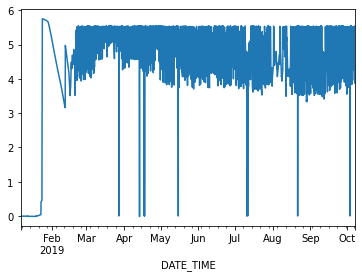

In [86]:
barrie_sample_test['Reservoir1_level'].plot()

## Pump & Gravity: orig ~> test

### no lags

In [52]:

Werneth_Park_feat = [
     "Hatters_Pump_1_Run_Status",
     "Hatters_Pump_2_Run_Status",
     "Pumped_flow_to_Oldham_Edge",
     "Werneth_Pump_1_Run_Status",
     "Westwood_SR_level_RESERVOIR_LEVEL"
    ]

tar_cols = ['Werneth_Park_SR_Level_RESERVOIR_LEVEL']

model_werneth = RandomForestRegressor(n_estimators = 60, 
                                      max_depth=20).fit(oldham_sample_train[Werneth_Park_feat], 
                                                        oldham_sample_train[tar_cols])



Werneth_Park_SR_Level_RESERVOIR_LEVEL mape (daily average): 9.492596999066357
Werneth_Park_SR_Level_RESERVOIR_LEVEL rmse (daily average): 0.4219906084393267


Werneth_Park_SR_Level_RESERVOIR_LEVEL          
                                   mape      rmse
0                              9.492597  0.421991

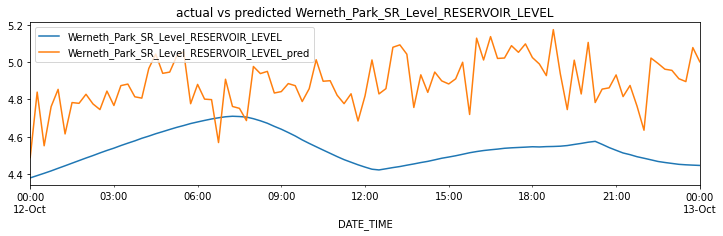

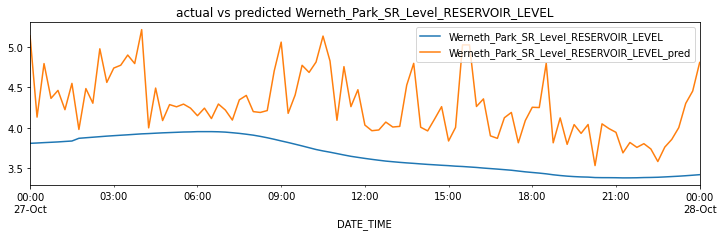

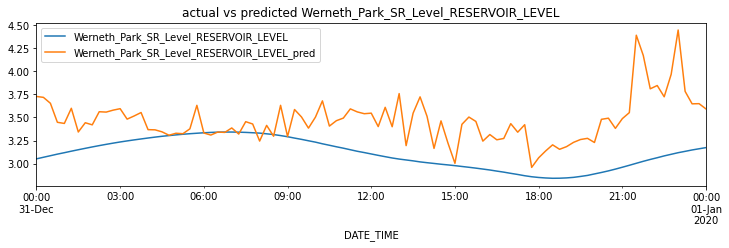

In [57]:

emg_eval.evaluation_daily(oldham_sample_test['2019-09-01 00:00:00':], model_werneth, Werneth_Park_feat, 
                    ['Werneth_Park_SR_Level_RESERVOIR_LEVEL'], diff_type=False)



### lags

In [79]:
hurdsfield_df = mclf_sample.copy()

hurdsfield_feat = ['ridgegate_WTW_flow', 'kerridge_SR_level', 'adlington_PS_flow', 'hurdsfield_SR_outflow_1']
tar_cols = ['hurdsfield_SR_level_1']

hurdsfield_df1 = hurdsfield_df[hurdsfield_feat]

hurdsfield_df1 = edpf.LagCreater(lags = [0,-6,-8,-10,-12]).transform(hurdsfield_df1, col='ridgegate_WTW_flow')
hurdsfield_df1 = edpf.LagCreater(lags = [0,-2,-4,-6]).transform(hurdsfield_df1, col='kerridge_SR_level')
hurdsfield_df1 = edpf.LagCreater(lags = [0,-4,-6,-8]).transform(hurdsfield_df1, col='adlington_PS_flow')
hurdsfield_df1 = edpf.LagCreater(lags = [0,-2,-3,-5]).transform(hurdsfield_df1, col='hurdsfield_SR_outflow_1')


hurdsfield_df1[tar_cols] = mclf_sample[tar_cols]

In [81]:

hurdsfield_df1= hurdsfield_df1.dropna()

hurdsfield_df1_train, hurdsfield_df1_test = train_test_split_ts(hurdsfield_df1)

hurdsfield_feat = [col for col in hurdsfield_df1.columns if col not in tar_cols]

In [82]:
model_hurdsfield = RandomForestRegressor(n_estimators = 60, 
                                      max_depth=20).fit(hurdsfield_df1_train[hurdsfield_feat], 
                                                        hurdsfield_df1_train['hurdsfield_SR_level_1'])



hurdsfield_SR_level_1 mape (daily average): 7.014429886408292
hurdsfield_SR_level_1 rmse (daily average): 0.2582736683353835


hurdsfield_SR_level_1          
                   mape      rmse
0               7.01443  0.258274

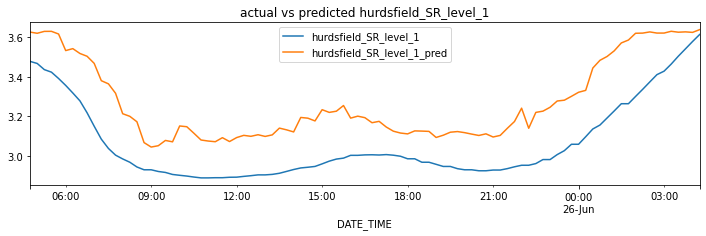

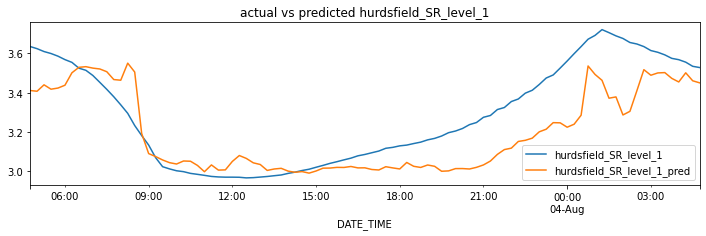

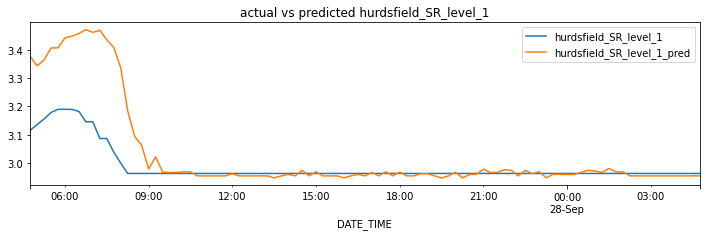

In [83]:
# orig model

emg_eval.evaluation_daily(hurdsfield_df1_test, model_hurdsfield, hurdsfield_feat, 
                    ['hurdsfield_SR_level_1'], diff_type=False)


In [85]:
hurdsfield_feat2 = ['kerridge_SR_level', 'adlington_PS_flow', "FW_temperature", 'cyclic_hr_x', 'cyclic_hr_y', 
             'cyclic_min_x', 'cyclic_min_y', 'cyclic_dayofmonth_x', 'cyclic_dayofmonth_y', 'cyclic_dayofweek_x', 
             'cyclic_dayofweek_y', 'cyclic_month_x', 'cyclic_month_y']

hurdsfield_df2 = hurdsfield_df[hurdsfield_feat2]

hurdsfield_df2 = edpf.LagCreater(lags = [0,-2,-4,-6]).transform(hurdsfield_df2, col='kerridge_SR_level')
hurdsfield_df2 = edpf.LagCreater(lags = [0,-4,-6,-8]).transform(hurdsfield_df2, col='adlington_PS_flow')

hurdsfield_df2[tar_cols] = mclf_sample[tar_cols]


In [86]:
hurdsfield_df2= hurdsfield_df2.dropna()

hurdsfield_df2_train, hurdsfield_df2_test = train_test_split_ts(hurdsfield_df2)

hurdsfield_feat2 = [col for col in hurdsfield_df2.columns if col not in tar_cols]


In [87]:
model_hurdsfield2 = RandomForestRegressor(n_estimators = 60, 
                                      max_depth=20).fit(hurdsfield_df2_train[hurdsfield_feat2], 
                                                        hurdsfield_df2_train['hurdsfield_SR_level_1'])



hurdsfield_SR_level_1 mape (daily average): 7.954158074703324
hurdsfield_SR_level_1 rmse (daily average): 0.29396023536570565


hurdsfield_SR_level_1         
                   mape     rmse
0              7.954158  0.29396

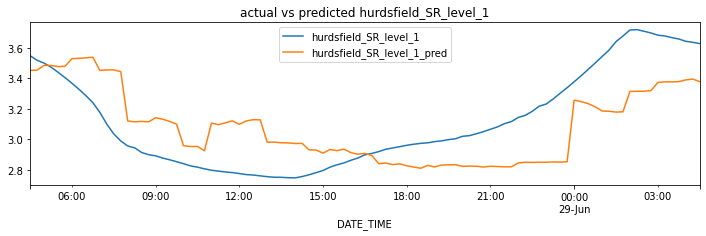

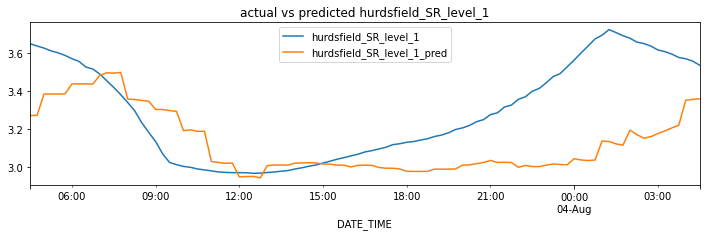

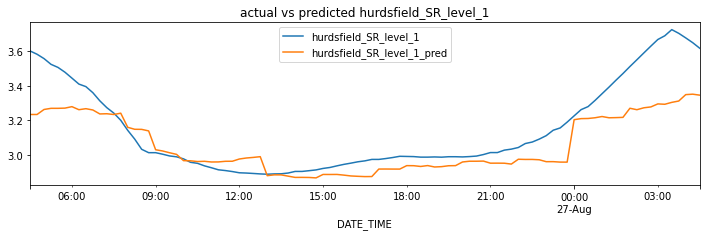

In [88]:
# test model

emg_eval.evaluation_daily(hurdsfield_df2_test, model_hurdsfield2, hurdsfield_feat2, 
                    ['hurdsfield_SR_level_1'], diff_type=False)

